### GPU Availability Check
This block verifies whether a CUDA-enabled GPU is accessible in the current environment using PyTorch. If a GPU is detected, it prints confirmation along with the GPU’s name; otherwise, it reports that no GPU is available.


In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")

### Package Installation
Installs all required Python libraries for data manipulation, machine learning, embeddings, visualization, and database operations. This ensures the environment has consistent dependencies before executing subsequent analysis or modeling steps.




In [1]:
%pip install polars pandas numpy scikit-learn xgboost lightgbm sentence-transformers umap-learn matplotlib seaborn plotly torch duckdb

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/783.6 kB ? eta -:--:--
   ---------------------------------------- 783.6/783.6 kB 14.0 MB/s  0:00:00
   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
   -- ------------------------------------- 2.9/41.3 MB 14.2 MB/s eta 0:00:03
   ----- ---------------------------------- 5.5/41.3 MB 13.9 MB/s eta 0:00:03
   ------- -------------------------------- 7.3/41.3 MB 12.0 MB/s eta 0:00:03
   -------- ------------------------------- 9.2/41.3 MB 11.8 MB/s eta 0:00:03
   ----------- ---------------------------- 12.3/41.3 MB 11.3 MB/s eta 0:00:03
   -------------- ------------------------- 14.9/41.3 MB 11.8 MB/s eta 0:00:03
   ----------------- ---------------------- 17.8/41.3 MB 11.9 MB/s eta 0:00:02
   ------------------- -------------------- 20.4/41.3 MB 11.8 MB/s eta 0:00:02
   ---------------------- ----------------- 23.6/41.3 MB 12.3 MB/s eta 0:00


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Library Imports
This block imports all core libraries required for the notebook’s workflow, covering data handling, visualization, machine learning, embeddings, and dimensionality reduction.

**Workflow**
1. **Data Handling** — Uses Polars, Pandas, and NumPy for efficient data manipulation and numerical operations.  
2. **Visualization** — Includes Matplotlib, Seaborn, and Plotly for static and interactive plots.  
3. **Machine Learning** — Loads Scikit-learn, XGBoost, and LightGBM for training and evaluating models.  
4. **Embeddings** — Imports SentenceTransformer and Torch for generating and managing embedding vectors.  
5. **Dimensionality Reduction** — Utilizes UMAP for projecting high-dimensional embeddings into lower dimensions.  
6. **SQL-style Queries** — Adds DuckDB for in-notebook querying and data exploration.

**Outputs**
- None directly; sets up all required modules for later analysis and modeling blocks.


In [9]:
# Core data handling
import polars as pl
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ML & preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report
from sklearn.decomposition import PCA
import xgboost as xgb
from lightgbm import LGBMRegressor, LGBMClassifier

# Embeddings
from sentence_transformers import SentenceTransformer
import torch

# Dimensionality reduction
import umap

# Optional: SQL-style exploration
import duckdb


### Define Data Source Paths
Specifies the file paths for the target dataset and the NBI feature dataset used in the bridge embedding workflow. These paths serve as inputs for subsequent data loading and preprocessing steps.


In [24]:
target_path = "C:\\Users\\wongb\\Bridge-ML\\Bridge-ML-LLM-Embedding-Architecture\\data\\targets_10Sep.csv"
NBIfeatures_path = "C:\\Users\\wongb\\Bridge-ML\\Bridge-ML-LLM-Embedding-Architecture\\data\\NBIfull.csv"

## Bridge Target Data Filtering
This block loads the bridge target dataset and applies several filters to remove non-qualifying or irrelevant records based on engineering and structural criteria. It provides detailed console outputs to track the effect of each filtering step on dataset size and content.

**Workflow**
1. **Data Loading** — Reads the raw targets CSV file into a Pandas DataFrame and logs the initial row count and shape.  
2. **Support Type Filtering** — Iteratively removes rows with specific “Support Type” values that are not relevant for analysis (e.g., walls, piles, or non-bridge entries).  
3. **Structure ID Filtering** — Removes entries where the “Structure ID” column matches invalid identifiers (e.g., “Not in BEISt”).  
4. **Feature Intersected Filtering** — Excludes rows where the “Feature Intersected” value indicates the entry is not a bridge.  
5. **Summary Report** — Prints a formatted summary showing how many rows remain after each stage and the total number removed. It also displays the remaining support type distribution.

**Outputs**
- Filtered DataFrame: `targets` containing only valid bridge entries.  
- `row_counts` dictionary summarizing how many rows remain after each filtering step.  
- Printed console report including:
  - Initial and final dataset shape  
  - Number and percentage of rows removed  
  - Counts of remaining support types


In [25]:
import pandas as pd

# === Load Data ===
targets = pd.read_csv(target_path)
print(f"✅ Starting Number of Bridges: {len(targets):,}")
print(f"   Shape: {targets.shape}")

# === Track filtering impact ===
row_counts = {"Initial": len(targets)}

# 1️⃣ Support Type removals
support_type_removals = {
    "Not in BEISt": "Excluded due to missing in BEISt",
    "Not Bridge": "Not an actual bridge",
    "Single Span": "Single-span bridges excluded",
    "Wall": "Wall support type removed",
    "Tapered Wall": "Tapered wall support type removed",
    "CIP Piles": "CIP pile supports removed",
    "Timber piles": "Timber piles removed",
    "Timber Piles": "Timber piles removed (alt casing)",
    "Composite Piles": "Composite piles removed",
    "PC Piles": "PC piles removed",
    "Piles": "Generic piles removed",
    "H-Piles": "H-piles removed",
    "Tapered Col": "Tapered columns removed",
}

print("\n🔍 Support Type Removals:")
for val, reason in support_type_removals.items():
    count = (targets["Support Type"] == val).sum()
    if count > 0:
        print(f"  - {reason}: {count:,} rows")
        targets = targets[targets["Support Type"] != val].copy()

row_counts["After Support Type Filter"] = len(targets)
print(f"\n✅ After Support Type Filter: {len(targets):,} rows (removed {row_counts['Initial'] - len(targets):,})")

# 2️⃣ Structure ID filter
structure_id_exclude = ["Not in BEISt"]
count_before = len(targets)
for value in structure_id_exclude:
    count = (targets["Structure ID"] == value).sum()
    if count > 0:
        print(f"\n🔍 Structure ID Filter: Removing {count:,} rows where Structure ID == '{value}'")
        targets = targets[targets["Structure ID"] != value].copy()

row_counts["After Structure ID Filter"] = len(targets)
print(f"✅ After Structure ID Filter: {len(targets):,} rows (removed {count_before - len(targets):,})")

# 3️⃣ Feature Intersected filter
feature_intersected_exclude = ["Not Bridge"]
count_before = len(targets)
for value in feature_intersected_exclude:
    count = (targets["Feature Intersected"] == value).sum()
    if count > 0:
        print(f"\n🔍 Feature Intersected Filter: Removing {count:,} rows where Feature Intersected == '{value}'")
        targets = targets[targets["Feature Intersected"] != value].copy()

row_counts["After Feature Intersected Filter"] = len(targets)
print(f"✅ After Feature Intersected Filter: {len(targets):,} rows (removed {count_before - len(targets):,})")

# === Summary ===
print("\n" + "="*60)
print("📊 FILTERING SUMMARY:")
print("="*60)
for step, count in row_counts.items():
    print(f"{step:.<40} {count:>6,} rows")

print("\n" + "="*60)
print(f"🎯 Final Shape: {targets.shape}")
print(f"📉 Total Removed: {row_counts['Initial'] - len(targets):,} rows ({(row_counts['Initial'] - len(targets)) / row_counts['Initial'] * 100:.1f}%)")
print("="*60)

print("\n🔢 Remaining Support Types:")
print(targets["Support Type"].value_counts())



✅ Starting Number of Bridges: 850
   Shape: (850, 11)

🔍 Support Type Removals:
  - Excluded due to missing in BEISt: 8 rows
  - Not an actual bridge: 27 rows
  - Single-span bridges excluded: 115 rows
  - Wall support type removed: 40 rows
  - CIP pile supports removed: 4 rows
  - Timber piles removed: 29 rows
  - Composite piles removed: 1 rows
  - PC piles removed: 76 rows
  - H-piles removed: 2 rows
  - Tapered columns removed: 45 rows

✅ After Support Type Filter: 503 rows (removed 347)

🔍 Structure ID Filter: Removing 16 rows where Structure ID == 'Not in BEISt'
✅ After Structure ID Filter: 487 rows (removed 16)
✅ After Feature Intersected Filter: 487 rows (removed 0)

📊 FILTERING SUMMARY:
Initial.................................    850 rows
After Support Type Filter...............    503 rows
After Structure ID Filter...............    487 rows
After Feature Intersected Filter........    487 rows

🎯 Final Shape: (487, 11)
📉 Total Removed: 363 rows (42.7%)

🔢 Remaining Support Ty

### Column Renaming for Consistency
Standardizes column names within the `targets` DataFrame to a uniform format suitable for analysis and downstream modeling.

**Workflow**
1. Defines a mapping (`rename_map`) from original column names to standardized, uppercase identifiers.  
2. Checks for any columns listed in the map that are missing from the dataset and logs them.  
3. Applies the renaming operation only to columns present in the DataFrame.  
4. Prints the number of successfully renamed columns and lists any skipped due to absence.

**Outputs**
- Updated `targets` DataFrame with consistent column naming conventions.  
- Console output summarizing the renaming results and any missing columns.


In [26]:
# --- Rename columns for consistency ---
rename_map = {
    'Structure ID': 'STRUCTURE_ID',
    'Spacing/Pitch (in)': 'SPACING_PITCH_IN',
    'No. of Columns/Piles per Bent': 'COLUMNS_PILES_PER_BENT',
    'B_long (in.)': 'B_LONG_IN',
    'B_trans (in.)': 'B_TRANS_IN',
    'Clear Height (ft)': 'CLEAR_HEIGHT_FT',
    'Support Type': 'SUPPORT_TYPE',
    'Feature Intersected': 'OBJECT_INTERSECTED',
    'Long Reinf Ratio, %': 'LRR',
    'Transverse Reinforcement Ratio': 'TRR',
    'Database Ref #': 'DATABASE_REF'
}

missing_cols = [col for col in rename_map if col not in targets.columns]
valid_renames = {k: v for k, v in rename_map.items() if k in targets.columns}
targets = targets.rename(columns=valid_renames)

print(f"✅ Renamed {len(valid_renames)} columns for consistency.")
if missing_cols:
    print(f"⚠️ Skipped missing columns: {missing_cols}")

✅ Renamed 11 columns for consistency.


## Engineered Feature Construction
This block computes new analytical and structural features derived from the cleaned bridge dataset. These engineered variables quantify geometric proportions, design properties, and condition-based classifications crucial for subsequent modeling and embedding.

**Workflow**
1. **Numeric Conversion** — Converts relevant dimension and reinforcement columns to numeric types to ensure accurate computation.  
2. **Column/Pile Binary Feature (`COLUMNS_PILES_0_1`)** — Encodes whether a bent has a single column/pile (`0`) or multiple (`1`).  
3. **Slenderness Ratios (`L_H_LONG`, `L_H_TRANS`, `L_H_MIN`)** — Calculates longitudinal and transverse height-to-width ratios (after converting feet to inches), then takes the minimum ratio as a measure of structural slenderness.  
4. **Material Constants Setup** — Defines fixed design parameters (e.g., concrete and steel strength) used in later formula-based calculations.  
5. **Structural Presence Indicator (`Z_KNOWN`)** — Encodes structural type based on column/pile binary variable.  
6. **Capacity-to-Demand Ratio (`CD_MIN`)** — Derives a simplified measure of structural efficiency using engineering constants and slenderness ratios; handles divide-by-zero conditions gracefully.  
7. **Critical Condition Flag (`CRITICAL_TRUTH_0_1`)** — Labels bridges as *critical* (`1`) if their `CD_MIN` ratio falls below 0.85, otherwise `0`.

**Outputs**
- Updated `targets` DataFrame with new engineered columns:  
  - `COLUMNS_PILES_0_1`, `L_H_LONG`, `L_H_TRANS`, `L_H_MIN`, `Z_KNOWN`, `CD_MIN`, `CRITICAL_TRUTH_0_1`  
- Console message confirming successful feature creation.



In [27]:
import numpy as np
import pandas as pd

# --- Engineered / Calculated Features ---

print("\n🧩 Adding engineered features...")

# === 1️⃣ Columns/Piles 0/1 ===
# Ensure numeric type first — coerce non-numerics to NaN
targets["COLUMNS_PILES_PER_BENT"] = pd.to_numeric(
    targets["COLUMNS_PILES_PER_BENT"], errors="coerce"
)

# Convert dimension columns to numeric
targets["B_LONG_IN"] = pd.to_numeric(targets["B_LONG_IN"], errors="coerce")
targets["B_TRANS_IN"] = pd.to_numeric(targets["B_TRANS_IN"], errors="coerce")
targets["CLEAR_HEIGHT_FT"] = pd.to_numeric(targets["CLEAR_HEIGHT_FT"], errors="coerce")
targets["LRR"] = pd.to_numeric(targets["LRR"], errors="coerce")
targets["TRR"] = pd.to_numeric(targets["TRR"], errors="coerce")

# 0 if exactly one pile/column per bent, 1 if more than one, NaN if missing.
targets["COLUMNS_PILES_0_1"] = np.select(
    [
        targets["COLUMNS_PILES_PER_BENT"].notna() & (targets["COLUMNS_PILES_PER_BENT"] == 1),
        targets["COLUMNS_PILES_PER_BENT"].notna() & (targets["COLUMNS_PILES_PER_BENT"] > 1),
    ],
    [0, 1],
    default=np.nan,
)
# Convert to nullable integer using pd.array for compatibility
targets["COLUMNS_PILES_0_1"] = pd.array(targets["COLUMNS_PILES_0_1"], dtype=pd.Int64Dtype())

# === 2️⃣ L/H Ratios ===
# Multiply by 12 to convert ft to in before ratio.
targets["L_H_LONG"] = (targets["CLEAR_HEIGHT_FT"] * 12) / targets["B_LONG_IN"]
targets["L_H_TRANS"] = (targets["CLEAR_HEIGHT_FT"] * 12) / targets["B_TRANS_IN"]

# Minimum slenderness ratio
targets["L_H_MIN"] = targets[["L_H_LONG", "L_H_TRANS"]].min(axis=1)

# === 3️⃣ Material / Design Constants ===
f_prime_c = 6000  # psi
f_y = 60000       # psi
f_y_t = 60000     # psi
eta = 0.5
pi_4 = np.pi / 4
C_0 = 1.6
C_1 = 1.3

sqrt_fc_fy = np.sqrt(f_prime_c) / f_y
fyt_fy = f_y_t / f_y

# === 4️⃣ Z_KNOWN (from pile/column presence) ===
targets["Z_KNOWN"] = targets["COLUMNS_PILES_0_1"].map({0: 1, 1: 2})

# === 5️⃣ Capacity / Demand Ratios ===
# The following calculations originate from the "Helper Tables" shear formulas in the old database.
# Some were commented out historically — kept as optional formulas for reference.

# Optional / inactive metrics (preserved for clarity)
# targets["CD_LONG"] = (
#     (C_0 * sqrt_fc_fy + 0.4 * targets["TRR"] * fyt_fy * targets["L_H_LONG"])
#     / (C_1 * 1 * pi_4 * eta * targets["LRR"])
# )
#
# targets["CD_TRANS"] = (
#     (C_0 * sqrt_fc_fy + 0.4 * targets["TRR"] * fyt_fy * targets["L_H_TRANS"])
#     / (C_1 * targets["Z_KNOWN"] * pi_4 * eta * targets["LRR"])
# )
#
# targets["CD_MIN"] = targets[["CD_LONG", "CD_TRANS"]].min(axis=1)

# Active formula used in previous version:
targets["CD_MIN"] = (
    (C_0 * sqrt_fc_fy + 0.5 * targets["TRR"] * fyt_fy) * targets["L_H_MIN"]
) / (C_1 * targets["Z_KNOWN"] * pi_4 * eta * targets["LRR"])

# Handle divide-by-zero or missing LRR safely
targets.loc[targets["LRR"] == 0, "CD_MIN"] = np.nan

# === 6️⃣ Critical Truth 0/1 ===
# 1 if CD_MIN < 0.85, 0 otherwise, NaN if missing.
targets["CRITICAL_TRUTH_0_1"] = np.where(
    targets["CD_MIN"].notna(),
    np.where(targets["CD_MIN"] < 0.85, 1, 0),
    np.nan,
)
# Convert to nullable integer using pd.array for compatibility
targets["CRITICAL_TRUTH_0_1"] = pd.array(targets["CRITICAL_TRUTH_0_1"], dtype=pd.Int64Dtype())

print("✅ Engineered features added successfully.")



🧩 Adding engineered features...
✅ Engineered features added successfully.


### Dataset Shape and Preview
Displays the current dimensions of the `targets` DataFrame (487 rows × 18 columns) and outputs the full table preview to visually confirm the results of filtering, renaming, and feature engineering steps.


In [28]:
targets.shape # Legacy shape was 823 x 18
targets

,DATABASE_REF,STRUCTURE_ID,OBJECT_INTERSECTED,SUPPORT_TYPE,COLUMNS_PILES_PER_BENT,B_LONG_IN,B_TRANS_IN,CLEAR_HEIGHT_FT,LRR,SPACING_PITCH_IN,TRR,COLUMNS_PILES_0_1,L_H_LONG,L_H_TRANS,L_H_MIN,Z_KNOWN,CD_MIN,CRITICAL_TRUTH_0_1
0,1,0019133A,Overpass,RectCol-Spiral,4.0,54.0,54.0,19.20,0.0155,6,0.0077,1,4.266667,4.266667,4.266667,2.0,1.594858,0
1,2,0019133D,Overpass,RectCol-Spiral,2.0,48.0,48.0,24.60,0.0140,4,0.0096,1,6.150000,6.150000,6.150000,2.0,2.953873,0
6,7,0005582A,Overpass,CircCol,4.0,36.0,36.0,34.40,0.0123,12,0.0020,1,11.466667,11.466667,11.466667,2.0,2.799066,0
7,8,0005523C,Overpass,CircCol,1.0,60.0,60.0,18.00,0.0099,12,0.0011,0,3.600000,3.600000,3.600000,1.0,1.863090,0
8,9,0005651A,Overpass,CircCol,1.0,72.0,72.0,25.20,0.0092,12,0.0010,0,4.200000,4.200000,4.200000,1.0,2.294276,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,843,0014567C,Terrain,CircCol,2.0,48.0,48.0,8.10,0.0172,3.5,0.0077,1,2.025000,2.025000,2.025000,2.0,0.682121,1
846,847,0014354A,Underpass,CircCol,4.0,36.0,36.0,25.31,0.0118,3.5,0.0067,1,8.436667,8.436667,8.436667,2.0,3.792290,0
847,848,0006068B,Underpass,CircCol,5.0,36.0,36.0,28.40,NaN,Missing,NaN,1,9.466667,9.466667,9.466667,2.0,NaN,<NA>
848,849,0017936A,Underpass,RectCol-Spiral,1.0,48.0,72.0,18.41,0.0199,4,NaN,0,4.602500,3.068333,3.068333,1.0,NaN,<NA>


### Column Reordering for Integration
Rearranges the `targets` DataFrame columns into a standardized order to ensure consistency when merging with other datasets or integrating into modeling pipelines. The new order prioritizes identifiers, geometric attributes, engineered features, and outcome variables for clearer organization.


In [29]:
# Reorder Columns before integration
new_order=['DATABASE_REF','STRUCTURE_ID','SUPPORT_TYPE', 'SPACING_PITCH_IN','COLUMNS_PILES_PER_BENT','COLUMNS_PILES_0_1',
           'CLEAR_HEIGHT_FT', 'B_LONG_IN', 'B_TRANS_IN', 'L_H_LONG','L_H_TRANS', 'L_H_MIN', 'LRR','TRR', 'Z_KNOWN',
           'CD_MIN','CRITICAL_TRUTH_0_1', 'OBJECT_INTERSECTED']

targets = targets[new_order].copy()

## NBI Feature Dataset Loading and Cleaning
This block loads and refines the **National Bridge Inventory (NBI)** feature dataset to ensure it aligns with the filtered target dataset and maintains analytical integrity.

**Workflow**
1. **Load Dataset** — Reads the raw NBI CSV file while skipping header rows (`skiprows=3`) to match historical preprocessing.  
2. **Filter by Structure ID** — Retains only records whose `Structure ID` values exist in the target dataset (`STRUCTURE_ID`), ensuring consistent bridge alignment across sources.  
3. **Drop Empty Columns** — Removes columns that are entirely missing (`NaN`) to streamline the feature space.  
4. **Missing-Value Analysis (Optional)** — Includes utility functions to print missing-value percentages (`print_null_percentages`) and optionally remove columns exceeding a missing-data threshold (`remove_high_nan`).  
5. **Remove Constant Columns** — Drops any features with a single repeated value across all rows, as they provide no variance for modeling.  
6. **Drop Irrelevant or Duplicate Columns** — Eliminates known reference, duplicate, and non-relevant metadata columns (e.g., route numbers, descriptive fields, coordinates duplicated elsewhere).  
7. **Missing-Value Summary** — Displays remaining columns with missing values for diagnostic purposes.  
8. **Column Renaming for Consistency** — Standardizes column names (e.g., converts `"Structure ID "` → `STRUCTURE_ID`, `"Lat. (Decimal Degrees)"` → `LAT`, etc.) and reports any skipped renames.

**Outputs**
- Cleaned `full_f` DataFrame containing relevant and consistent NBI features.  
- Printed summary of:
  - Number of remaining rows and columns  
  - Dropped columns and reasons  
  - Missing-value report  
  - Confirmation of successful column renaming.


In [30]:
import pandas as pd

print("\n🧩 Loading and cleaning NBI feature dataset...")

# === 1️⃣ Load Features ===
# skiprows=3 keeps the same behavior as original script
full_f = pd.read_csv(NBIfeatures_path, skiprows=3)
print(f"✅ Loaded NBI features: {full_f.shape[0]:,} rows × {full_f.shape[1]:,} columns")

# === 2️⃣ Filter by Structure IDs that exist in KBC targets ===
if "Structure ID " in full_f.columns and "STRUCTURE_ID" in targets.columns:
    full_f = full_f[full_f["Structure ID "].isin(targets["STRUCTURE_ID"])].copy()
    print(f"🔍 Filtered by STRUCTURE_ID — remaining rows: {len(full_f):,}")
else:
    print("⚠️ Warning: 'Structure ID ' column not found in features or 'STRUCTURE_ID' missing in targets.")

# === 3️⃣ Drop columns with all missing values ===
num_missing_drop = full_f.shape[1] - full_f.dropna(axis=1, how="all").shape[1]
if num_missing_drop > 0:
    print(f"🧹 Dropping {num_missing_drop} columns that are entirely NaN.")
    full_f = full_f.dropna(axis=1, how="all").copy()

# === 4️⃣ Optional missing-value filtering (commented out historically) ===
def print_null_percentages(df):
    """Utility to display percent of missing per column."""
    percent_missing = df.isnull().mean() * 100
    print("📊 Percentage of missing values per column:")
    print(percent_missing.round(2))
    return percent_missing

def remove_high_nan(df, threshold_percent=5):
    """Remove columns with more than threshold% NaN values."""
    percent_missing = print_null_percentages(df)
    cols_to_drop = percent_missing[percent_missing > threshold_percent].index
    if len(cols_to_drop) > 0:
        print(f"🧹 Removing {len(cols_to_drop)} columns with >{threshold_percent}% missing values.")
        df = df.drop(columns=cols_to_drop)
    return df

# Optional — uncomment to apply stricter NaN filtering
# full_f = remove_high_nan(full_f, threshold_percent=5)

# === 5️⃣ Remove columns with constant values ===
constant_cols = [c for c in full_f.columns if full_f[c].nunique(dropna=False) == 1]
if constant_cols:
    print(f"🗑️ Dropping {len(constant_cols)} constant columns: {constant_cols}")
    full_f = full_f.drop(columns=constant_cols).copy()

# === 6️⃣ Optional uniqueness filter (commented out previously) ===
# threshold = 0.9 * len(full_f)
# high_unique = [c for c in full_f.columns if full_f[c].nunique() >= threshold]
# print(f"Columns with ≥90% unique values: {high_unique}")
# full_f = full_f.drop(columns=high_unique).copy()

# === 7️⃣ Drop irrelevant / reference / duplicate columns ===
reference_columns = [
    "In OP?", "In T2T?", "In National Network?", "STRUCTURE_NUMBER_008",
    # "Special Single Span?"  # optional
]
dup_columns = ["LAT_016", "LONG_017"]
not_rel_columns = ["Bridge #"]
# "OTHR_STATE_STRUC_NO_099", "MAINTENANCE_021", "OWNER_022" # optional

for label, cols in {
    "reference": reference_columns,
    "duplicate": dup_columns,
    "not_relevant": not_rel_columns,
}.items():
    existing = [c for c in cols if c in full_f.columns]
    if existing:
        print(f"🗑️ Dropping {len(existing)} {label} columns: {existing}")
        full_f = full_f.drop(columns=existing).copy()
    else:
        print(f"ℹ️ No {label} columns found to drop.")

# === 8️⃣ Remaining feature summary ===
print(f"\n📦 Remaining features: {full_f.shape[1]} columns")
missing_values = full_f.isna().sum()
columns_with_missing = missing_values[missing_values > 0]
if not columns_with_missing.empty:
    print("\n⚠️ Columns with missing values:")
    print(columns_with_missing)

# === 9️⃣ Rename columns for consistency ===
rename_map = {
    "Structure ID ": "STRUCTURE_ID",
    "Long. (Decimal Degrees)": "LONG",
    "Lat. (Decimal Degrees)": "LAT",
}
existing_renames = {k: v for k, v in rename_map.items() if k in full_f.columns}
missing_rename = [k for k in rename_map if k not in full_f.columns]
if missing_rename:
    print(f"⚠️ Skipping missing columns during rename: {missing_rename}")
full_f = full_f.rename(columns=existing_renames)
print("✅ Column renaming completed.")



🧩 Loading and cleaning NBI feature dataset...
✅ Loaded NBI features: 4,914 rows × 133 columns
🔍 Filtered by STRUCTURE_ID — remaining rows: 478
🧹 Dropping 6 columns that are entirely NaN.
🗑️ Dropping 14 constant columns: ['Special Single Span?', 'ADT > (parameter)?', 'STATE_CODE_001', 'RECORD_TYPE_005A', 'DIRECTION_005E', 'PLACE_CODE_004', 'MAINTENANCE_021', 'OWNER_022', 'CULVERT_COND_062', 'WORK_DONE_BY_075B', 'OTHR_STATE_STRUC_NO_099', 'BRIDGE_LEN_IND_112', 'FED_AGENCY', 'SUBMITTED_BY']
🗑️ Dropping 4 reference columns: ['In OP?', 'In T2T?', 'In National Network?', 'STRUCTURE_NUMBER_008']
🗑️ Dropping 2 duplicate columns: ['LAT_016', 'LONG_017']
🗑️ Dropping 1 not_relevant columns: ['Bridge #']

📦 Remaining features: 106 columns

⚠️ Columns with missing values:
LRS_INV_ROUTE_013A         447
SUBROUTE_NO_013B           179
FRACTURE_LAST_DATE_093A    469
UNDWATER_LAST_DATE_093B    468
SPEC_LAST_DATE_093C        473
PIER_PROTECTION_111        473
dtype: int64
✅ Column renaming completed.


### Display Full NBI Feature Dataset
Expands Pandas’ display settings to show all columns (`display.max_columns=None`) and outputs the complete `full_f` DataFrame. This allows for a full visual inspection of the cleaned NBI feature dataset after filtering and renaming.


In [31]:
pd.set_option('display.max_columns', None)
full_f

,STRUCTURE_ID,LAT,LONG,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009,MIN_VERT_CLR_010,KILOPOINT_011,BASE_HWY_NETWORK_012,LRS_INV_ROUTE_013A,SUBROUTE_NO_013B,DETOUR_KILOS_019,TOLL_020,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,YEAR_ADT_030,DESIGN_LOAD_031,APPR_WIDTH_MT_032,MEDIAN_CODE_033,DEGREES_SKEW_034,STRUCTURE_FLARED_035,RAILINGS_036A,TRANSITIONS_036B,APPR_RAIL_036C,APPR_RAIL_END_036D,HISTORY_037,NAVIGATION_038,NAV_VERT_CLR_MT_039,NAV_HORR_CLR_MT_040,OPEN_CLOSED_POSTED_041,SERVICE_ON_042A,SERVICE_UND_042B,STRUCTURE_KIND_043A,STRUCTURE_TYPE_043B,APPR_KIND_044A,APPR_TYPE_044B,MAIN_UNIT_SPANS_045,APPR_SPANS_046,HORR_CLR_MT_047,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,LEFT_CURB_MT_050A,RIGHT_CURB_MT_050B,ROADWAY_WIDTH_MT_051,DECK_WIDTH_MT_052,VERT_CLR_OVER_MT_053,VERT_CLR_UND_REF_054A,VERT_CLR_UND_054B,LAT_UND_REF_055A,LAT_UND_MT_055B,LEFT_LAT_UND_MT_056,DECK_COND_058,SUPERSTRUCTURE_COND_059,SUBSTRUCTURE_COND_060,CHANNEL_COND_061,OPR_RATING_METH_063,OPERATING_RATING_064,INV_RATING_METH_065,INVENTORY_RATING_066,STRUCTURAL_EVAL_067,DECK_GEOMETRY_EVAL_068,UNDCLRENCE_EVAL_069,POSTING_EVAL_070,WATERWAY_EVAL_071,APPR_ROAD_EVAL_072,WORK_PROPOSED_075A,IMP_LEN_MT_076,DATE_OF_INSPECT_090,INSPECT_FREQ_MONTHS_091,FRACTURE_092A,UNDWATER_LOOK_SEE_092B,SPEC_INSPECT_092C,FRACTURE_LAST_DATE_093A,UNDWATER_LAST_DATE_093B,SPEC_LAST_DATE_093C,BRIDGE_IMP_COST_094,ROADWAY_IMP_COST_095,TOTAL_IMP_COST_096,YEAR_OF_IMP_097,STRAHNET_HIGHWAY_100,PARALLEL_STRUCTURE_101,TRAFFIC_DIRECTION_102,HIGHWAY_SYSTEM_104,FEDERAL_LANDS_105,YEAR_RECONSTRUCTED_106,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,PERCENT_ADT_TRUCK_109,NATIONAL_NETWORK_110,PIER_PROTECTION_111,SCOUR_CRITICAL_113,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA
73,000000QC,47.412111,-122.221500,5,1,0,1,33,'SR 167 & SPRINGBROOK CK','S 212TH ST','1.8 N JCT SR 516',99.99,0.048,1,167LX02240,0.0,0,3,14,1973,5,7,31076,2016,6,17.7,0,1,0,1,0,0,0,5,0,0.0,0.0,A,1,6,5,2,0,0,3,0,18.6,31.4,96.6,1.5,0.0,18.6,20.9,99.99,H,4.95,H,10.2,1.7,7,6,7,8,1,85.3,1,49.9,6,3,5,5,8,8,35.0,96.6,321,24,N,N,N,NaN,NaN,NaN,3804.0,761.0,7608.0,2014.0,0,N,2,1,0,1992.0,1,1,0,0,5.0,0,NaN,8,48668,2038,F,6,2018.94
84,00000KMA,47.827028,-122.268972,5,1,0,1,61,'I-5','ALDERWOOD MALL PKW','0.6 N JCT SR 524',99.99,0.032,0,NaN,NaN,2,3,16,1996,6,10,2635,2002,9,20.7,0,49,0,1,1,1,1,4,N,0.0,0.0,A,5,1,6,2,0,0,4,0,20.7,46.0,155.1,2.4,2.4,20.7,25.9,99.99,H,4.90,H,3.0,3.0,7,7,7,N,1,89.8,1,74.4,7,2,4,5,N,8,35.0,155.1,721,24,N,N,N,NaN,NaN,NaN,7126.0,1425.0,14252.0,2014.0,0,N,2,0,0,0.0,1,1,0,1,5.0,0,NaN,N,4785,2036,G,7,4017.09
147,0001406A,48.066111,-124.235250,2,1,101,3,9,'BEAR CREEK','US 101','2.2 N JCT SR 113',99.99,331.541,1,NaN,0.0,27,3,2,1930,2,0,2496,2019,2,10.4,0,0,0,1,1,1,1,5,0,0.0,0.0,A,1,5,2,2,0,0,12,0,7.9,18.3,134.1,0.2,0.2,7.9,9.1,99.99,N,0.00,N,0.0,0.0,7,6,6,8,1,41.7,1,25.4,6,3,N,5,8,8,35.0,134.1,818,48,N,N,N,NaN,NaN,NaN,3168.0,634.0,6336.0,2014.0,0,N,2,1,0,1957.0,1,6,2,0,12.0,1,NaN,5,3124,2039,F,6,1220.31
160,0001576A,46.879492,-123.271575,2,1,12,3,27,'CEDAR CREEK','US 12','10.5 E JCT SR 8',99.99,51.177,1,NaN,0.0,5,3,2,1932,2,0,5972,2019,2,9.8,0,0,0,1,0,1,0,5,0,0.0,0.0,A,1,5,1,4,0,0,3,0,7.3,18.3,36.9,0.0,0.0,7.3,8.2,99.99,N,0.00,N,0.0,0.0,7,6,6,5,1,65.3,1,39.0,6,2,N,5,8,8,35.0,36.9,920,24,N,N,N,NaN,NaN,NaN,823.0,165.0,1646.0,2014.0,0,N,2,1,0,0.0,1,6,2,0,16.0,1,NaN,3,6831,2039,F,6,302.58
161,0001576B,46.847933,-123.248556,2,1,12,3,27,'RAILROAD','US 12','13.0 E JCT SR 8',99.99,55.120,1,NaN,0.0,8,3,2,1932,2,0,5972,2019,2,10.4,0,45,0,1,0,1,0,5,N,0.0,0.0,A,1,2,1,4,0,0,3,0,7.3,16.5,49.7,0.0,0.0,7.3,8.2,99.99,R,6.88,R,5.2,0.0,6,5,6,N,1,65.3,1,39.0,5,2,7,5,N,8,35.0,49.7,620,24,N,N,N,NaN,NaN,NaN,1174.0,235.0,2347.0,2014.0,0,N,2,1,0,0.0,1,6,2,0,16.0,1,NaN,N,6831,2039,F,5,407.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

## Enforce Consistent Data Types for NBI Features
This block standardizes the data types of all NBI feature columns to ensure numerical and categorical consistency across the dataset. Proper type enforcement is essential for downstream modeling, merging, and statistical analysis.

**Workflow**
1. **Define Data Type Map** — A predefined `dtype_map` dictionary specifies the intended type (e.g., `float`, `int`, `str`) for each feature column based on its semantic meaning.  
2. **Check Column Existence** — Identifies and reports any columns present in the `dtype_map` that are missing from the DataFrame, skipping their conversion.  
3. **Safe Type Conversion** — Iterates through existing columns and attempts to convert each to its designated data type, handling exceptions gracefully with warning messages.  
4. **Completion Message** — Confirms successful data type enforcement once all applicable columns have been processed.

**Outputs**
- Updated `full_f` DataFrame with consistent column data types.  
- Console logs detailing:
  - Missing columns from the dtype map  
  - Any conversion issues  
  - Final confirmation of completion.


In [32]:
print("\n🧩 Enforcing column data types for NBI features...")

# Define your dtype map (fixed minor typo in ROUTE key)
dtype_map = {
    "STRUCTURE_ID": str,
    "LAT": float,
    "LONG": float,
    "ROUTE_PREFIX_005B": int,
    "SERVICE_LEVEL_005C": int,
    "ROUTE_NUMBER_005D": str,
    "HIGHWAY_DISTRICT_002": int,
    "COUNTY_CODE_003": int,
    "FEATURES_DESC_006A": str,
    "FACILITY_CARRIED_007": str,
    "LOCATION_009": str,
    "MIN_VERT_CLR_010": float,
    "KILOPOINT_011": float,
    "BASE_HWY_NETWORK_012": int,
    "DETOUR_KILOS_019": int,
    "TOLL_020": int,
    "FUNCTIONAL_CLASS_026": int,
    "YEAR_BUILT_027": int,
    "TRAFFIC_LANES_ON_028A": int,
    "TRAFFIC_LANES_UND_028B": int,
    "ADT_029": int,
    "YEAR_ADT_030": int,
    "DESIGN_LOAD_031": str,
    "APPR_WIDTH_MT_032": float,
    "MEDIAN_CODE_033": int,
    "DEGREES_SKEW_034": int,
    "STRUCTURE_FLARED_035": int,
    "RAILINGS_036A": str,
    "TRANSITIONS_036B": str,
    "APPR_RAIL_036C": str,
    "APPR_RAIL_END_036D": str,
    "HISTORY_037": int,
    "NAVIGATION_038": str,
    "NAV_VERT_CLR_MT_039": float,
    "NAV_HORR_CLR_MT_040": float,
    "OPEN_CLOSED_POSTED_041": str,
    "SERVICE_ON_042A": int,
    "SERVICE_UND_042B": int,
    "STRUCTURE_KIND_043A": int,
    "STRUCTURE_TYPE_043B": int,
    "APPR_KIND_044A": int,
    "APPR_TYPE_044B": int,
    "MAIN_UNIT_SPANS_045": int,
    "APPR_SPANS_046": int,
    "HORR_CLR_MT_047": float,
    "MAX_SPAN_LEN_MT_048": float,
    "STRUCTURE_LEN_MT_049": float,
    "LEFT_CURB_MT_050A": float,
    "RIGHT_CURB_MT_050B": float,
    "ROADWAY_WIDTH_MT_051": float,
    "DECK_WIDTH_MT_052": float,
    "VERT_CLR_OVER_MT_053": float,
    "VERT_CLR_UND_REF_054A": str,
    "VERT_CLR_UND_054B": float,
    "LAT_UND_REF_055A": str,
    "LAT_UND_MT_055B": float,
    "LEFT_LAT_UND_MT_056": float,
    "DECK_COND_058": str,
    "SUPERSTRUCTURE_COND_059": str,
    "SUBSTRUCTURE_COND_060": str,
    "CHANNEL_COND_061": str,
    "OPR_RATING_METH_063": int,
    "OPERATING_RATING_064": float,
    "INV_RATING_METH_065": int,
    "INVENTORY_RATING_066": float,
    "STRUCTURAL_EVAL_067": str,
    "DECK_GEOMETRY_EVAL_068": str,
    "UNDCLRENCE_EVAL_069": str,
    "POSTING_EVAL_070": int,
    "WATERWAY_EVAL_071": str,
    "APPR_ROAD_EVAL_072": int,
    "WORK_PROPOSED_075A": int,
    "IMP_LEN_MT_076": float,
    "DATE_OF_INSPECT_090": int,
    "INSPECT_FREQ_MONTHS_091": int,
    "FRACTURE_092A": str,
    "UNDWATER_LOOK_SEE_092B": str,
    "SPEC_INSPECT_092C": str,
    "BRIDGE_IMP_COST_094": int,
    "ROADWAY_IMP_COST_095": int,
    "TOTAL_IMP_COST_096": int,
    "YEAR_OF_IMP_097": int,
    "STRAHNET_HIGHWAY_100": int,
    "PARALLEL_STRUCTURE_101": str,
    "TRAFFIC_DIRECTION_102": int,
    "HIGHWAY_SYSTEM_104": int,
    "FEDERAL_LANDS_105": int,
    "YEAR_RECONSTRUCTED_106": int,
    "DECK_STRUCTURE_TYPE_107": str,
    "SURFACE_TYPE_108A": str,
    "MEMBRANE_TYPE_108B": str,
    "DECK_PROTECTION_108C": str,
    "PERCENT_ADT_TRUCK_109": int,
    "NATIONAL_NETWORK_110": int,
    "SCOUR_CRITICAL_113": str,
    "FUTURE_ADT_114": int,
    "YEAR_OF_FUTURE_ADT_115": int,
    "BRIDGE_CONDITION": str,
    "LOWEST_RATING": int,
    "DECK_AREA": float,
}

# --- Check which columns are missing ---
missing_dtype_cols = [col for col in dtype_map if col not in full_f.columns]

if missing_dtype_cols:
    print(f"⚠️ Warning: {len(missing_dtype_cols)} columns from dtype_map were not found in the dataset.")
    print("   Missing columns:", ", ".join(missing_dtype_cols))
    # Filter dtype map to existing columns only
    dtype_map = {k: v for k, v in dtype_map.items() if k in full_f.columns}
else:
    print("✅ All columns in dtype_map found in the dataframe.")

# --- Apply dtype conversions safely ---
for col, dtype in dtype_map.items():
    try:
        full_f[col] = full_f[col].astype(dtype)
    except Exception as e:
        print(f"⚠️ Could not convert {col} to {dtype.__name__}: {e}")

print("\n✅ Column data types enforced successfully.")



🧩 Enforcing column data types for NBI features...
✅ All columns in dtype_map found in the dataframe.

✅ Column data types enforced successfully.


## Feature Type Categorization
This block organizes the cleaned NBI feature dataset into logical groups based on variable type, which helps guide preprocessing, encoding, and modeling strategies in subsequent stages.

**Workflow**
1. **Define Column Groups**
   - **Numeric Columns** — Continuous or quantitative features (e.g., bridge dimensions, traffic counts, inspection years).  
   - **Binary Columns** — Two-valued categorical variables typically encoded as 0/1 or yes/no flags.  
   - **Nominal Columns** — Unordered categorical variables such as structural materials, codes, or descriptive attributes.  
   - **Ordinal Columns** — Ordered categorical variables representing condition ratings or evaluations (e.g., deck condition).  
2. **Validation**
   - Checks whether each listed column exists in the dataset and warns if any are missing.  
   - Ensures there is no overlap between groups to maintain clean feature separation.  
3. **Completion**
   - Prints confirmation messages summarizing which feature groups were fully or partially matched.

**Outputs**
- Four categorized column lists: `numeric_cols`, `binary_cols`, `nominal_cols`, `ordinal_cols`.  
- Console output summarizing validation results and potential missing or duplicate features.  
- Prepares the dataset for consistent encoding and analysis workflows.


In [33]:
print("\n🧩 Categorizing feature types...")

# --- Numeric Columns ---
numeric_cols = [
    "LAT", "LONG", "MIN_VERT_CLR_010", "KILOPOINT_011", "DETOUR_KILOS_019",
    "YEAR_BUILT_027", "TRAFFIC_LANES_ON_028A", "TRAFFIC_LANES_UND_028B",
    "ADT_029", "YEAR_ADT_030", "APPR_WIDTH_MT_032", "DEGREES_SKEW_034",
    "NAV_VERT_CLR_MT_039", "NAV_HORR_CLR_MT_040", "MAIN_UNIT_SPANS_045",
    "APPR_SPANS_046", "HORR_CLR_MT_047", "MAX_SPAN_LEN_MT_048",
    "STRUCTURE_LEN_MT_049", "LEFT_CURB_MT_050A", "RIGHT_CURB_MT_050B",
    "ROADWAY_WIDTH_MT_051", "DECK_WIDTH_MT_052", "VERT_CLR_OVER_MT_053",
    "VERT_CLR_UND_054B", "LAT_UND_MT_055B", "LEFT_LAT_UND_MT_056",
    "OPERATING_RATING_064", "INVENTORY_RATING_066", "IMP_LEN_MT_076",
    "DATE_OF_INSPECT_090", "BRIDGE_IMP_COST_094", "ROADWAY_IMP_COST_095",
    "TOTAL_IMP_COST_096", "YEAR_OF_IMP_097", "YEAR_RECONSTRUCTED_106",
    "PERCENT_ADT_TRUCK_109", "FUTURE_ADT_114", "YEAR_OF_FUTURE_ADT_115",
    "LOWEST_RATING", "DECK_AREA"
]

# --- Binary Columns ---
binary_cols = [
    "BASE_HWY_NETWORK_012", "STRUCTURE_FLARED_035",
    "INSPECT_FREQ_MONTHS_091", "HIGHWAY_SYSTEM_104",
    "NATIONAL_NETWORK_110"
]

# --- Nominal Columns (unordered categories) ---
nominal_cols = [
    "ROUTE_PREFIX_005B", "SERVICE_LEVEL_005C", "HIGHWAY_DISTRICT_002",
    "COUNTY_CODE_003", "TOLL_020", "FUNCTIONAL_CLASS_026", "DESIGN_LOAD_031",
    "MEDIAN_CODE_033", "RAILINGS_036A", "TRANSITIONS_036B", "APPR_RAIL_036C",
    "APPR_RAIL_END_036D", "HISTORY_037", "NAVIGATION_038", "OPEN_CLOSED_POSTED_041",
    "SERVICE_ON_042A", "SERVICE_UND_042B", "STRUCTURE_KIND_043A",
    "STRUCTURE_TYPE_043B", "APPR_KIND_044A", "APPR_TYPE_044B",
    "VERT_CLR_UND_REF_054A", "LAT_UND_REF_055A", "OPR_RATING_METH_063",
    "INV_RATING_METH_065", "WORK_PROPOSED_075A", "FRACTURE_092A",
    "UNDWATER_LOOK_SEE_092B", "SPEC_INSPECT_092C", "STRAHNET_HIGHWAY_100",
    "PARALLEL_STRUCTURE_101", "TRAFFIC_DIRECTION_102", "FEDERAL_LANDS_105",
    "DECK_STRUCTURE_TYPE_107", "SURFACE_TYPE_108A", "MEMBRANE_TYPE_108B",
    "DECK_PROTECTION_108C", "SCOUR_CRITICAL_113", "FEATURES_DESC_006A", "FACILITY_CARRIED_007", "LOCATION_009", "ROUTE_NUMBER_005D"
]

# --- Ordinal Columns (ordered categories) ---
ordinal_cols = [
    "DECK_COND_058", "SUPERSTRUCTURE_COND_059", "SUBSTRUCTURE_COND_060",
    "CHANNEL_COND_061", "STRUCTURAL_EVAL_067", "DECK_GEOMETRY_EVAL_068",
    "UNDCLRENCE_EVAL_069", "POSTING_EVAL_070", "WATERWAY_EVAL_071",
    "APPR_ROAD_EVAL_072", "BRIDGE_CONDITION"
]

# === Validation ===
expected_groups = {
    "Numeric": numeric_cols,
    "Binary": binary_cols,
    "Nominal": nominal_cols,
    "Ordinal": ordinal_cols
}

# Check for missing columns in each category
for group_name, cols in expected_groups.items():
    missing = [c for c in cols if c not in full_f.columns]
    if missing:
        print(f"⚠️ {len(missing)} {group_name} columns not found in dataset: {missing}")
    else:
        print(f"✅ All {group_name.lower()} columns found ({len(cols)}).")

# Optional: ensure no overlap between groups
all_cols = numeric_cols + binary_cols + nominal_cols + ordinal_cols
if len(all_cols) != len(set(all_cols)):
    print("⚠️ Warning: Duplicate columns found across feature groups!")

print("✅ Feature type categorization completed.")



🧩 Categorizing feature types...
✅ All numeric columns found (41).
✅ All binary columns found (5).
✅ All nominal columns found (42).
✅ All ordinal columns found (11).
✅ Feature type categorization completed.


## Merge Cleaned Target and NBI Feature Datasets
Combines the processed **bridge target dataset** with the **NBI feature dataset** into a unified table for downstream modeling and embedding generation.

**Workflow**
1. **Inner Merge** — Joins the two DataFrames on the shared key `STRUCTURE_ID` to ensure only bridges present in both datasets are retained.  
2. **Index Assignment** — Sets `DATABASE_REF` as the new index to provide a unique reference for each bridge record.  
3. **Integrity Check** — Confirms the merged dataset dimensions, ensuring proper alignment (478 rows × 114 columns, excluding 9 bridges not found in NBI).

**Outputs**
- Final merged DataFrame `merged_1`, containing structural, geometric, and contextual bridge features aligned for modeling.  
- Console comments summarizing record retention and merged shape.


In [34]:
# Merge DataFrames on 'Structure ID'
merged_1 = pd.merge(targets, full_f, on='STRUCTURE_ID', how='inner')

# Make Database_Ref the index
merged_1 = merged_1.set_index('DATABASE_REF').copy()

merged_1 

,STRUCTURE_ID,SUPPORT_TYPE,SPACING_PITCH_IN,COLUMNS_PILES_PER_BENT,COLUMNS_PILES_0_1,CLEAR_HEIGHT_FT,B_LONG_IN,B_TRANS_IN,L_H_LONG,L_H_TRANS,L_H_MIN,LRR,TRR,Z_KNOWN,CD_MIN,CRITICAL_TRUTH_0_1,OBJECT_INTERSECTED,LAT,LONG,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009,MIN_VERT_CLR_010,KILOPOINT_011,BASE_HWY_NETWORK_012,LRS_INV_ROUTE_013A,SUBROUTE_NO_013B,DETOUR_KILOS_019,TOLL_020,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,YEAR_ADT_030,DESIGN_LOAD_031,APPR_WIDTH_MT_032,MEDIAN_CODE_033,DEGREES_SKEW_034,STRUCTURE_FLARED_035,RAILINGS_036A,TRANSITIONS_036B,APPR_RAIL_036C,APPR_RAIL_END_036D,HISTORY_037,NAVIGATION_038,NAV_VERT_CLR_MT_039,NAV_HORR_CLR_MT_040,OPEN_CLOSED_POSTED_041,SERVICE_ON_042A,SERVICE_UND_042B,STRUCTURE_KIND_043A,STRUCTURE_TYPE_043B,APPR_KIND_044A,APPR_TYPE_044B,MAIN_UNIT_SPANS_045,APPR_SPANS_046,HORR_CLR_MT_047,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,LEFT_CURB_MT_050A,RIGHT_CURB_MT_050B,ROADWAY_WIDTH_MT_051,DECK_WIDTH_MT_052,VERT_CLR_OVER_MT_053,VERT_CLR_UND_REF_054A,VERT_CLR_UND_054B,LAT_UND_REF_055A,LAT_UND_MT_055B,LEFT_LAT_UND_MT_056,DECK_COND_058,SUPERSTRUCTURE_COND_059,SUBSTRUCTURE_COND_060,CHANNEL_COND_061,OPR_RATING_METH_063,OPERATING_RATING_064,INV_RATING_METH_065,INVENTORY_RATING_066,STRUCTURAL_EVAL_067,DECK_GEOMETRY_EVAL_068,UNDCLRENCE_EVAL_069,POSTING_EVAL_070,WATERWAY_EVAL_071,APPR_ROAD_EVAL_072,WORK_PROPOSED_075A,IMP_LEN_MT_076,DATE_OF_INSPECT_090,INSPECT_FREQ_MONTHS_091,FRACTURE_092A,UNDWATER_LOOK_SEE_092B,SPEC_INSPECT_092C,FRACTURE_LAST_DATE_093A,UNDWATER_LAST_DATE_093B,SPEC_LAST_DATE_093C,BRIDGE_IMP_COST_094,ROADWAY_IMP_COST_095,TOTAL_IMP_COST_096,YEAR_OF_IMP_097,STRAHNET_HIGHWAY_100,PARALLEL_STRUCTURE_101,TRAFFIC_DIRECTION_102,HIGHWAY_SYSTEM_104,FEDERAL_LANDS_105,YEAR_RECONSTRUCTED_106,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,PERCENT_ADT_TRUCK_109,NATIONAL_NETWORK_110,PIER_PROTECTION_111,SCOUR_CRITICAL_113,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA
DATABASE_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0019133A,RectCol-Spiral,6,4.0,1,19.20,54.0,54.0,4.266667,4.266667,4.266667,0.0155,0.0077,2.0,1.594858,0,Overpass,47.118583,-122.557083,5,1,0,3,53,'I-5','BERKELEY ST','7.7 N THURSTON CO',99.99,0.001,0,NaN,NaN,5,3,16,2020,5,8,14599,2010,A,19.5,0,4,1,1,1,1,1,5,N,0.0,0.0,G,5,4,6,2,0,0,4,0,17.4,48.2,159.1,0.0,4.3,16.8,26.2,99.99,H,5.54,H,3.4,2.4,8,8,8,N,8,47.3,8,35.3,8,2,5,5,N,8,35,159.1,320,24,N,N,N,NaN,NaN,NaN,6890,1378,13781,2014,0,N,2,0,0,0,1,1,0,1,2,0,NaN,N,23709,2036,G,8,4168.42
2,0019133D,RectCol-Spiral,4,2.0,1,24.60,48.0,48.0,6.150000,6.150000,6.150000,0.0140,0.0096,2.0,2.953873,0,Overpass,47.127006,-122.544067,5,1,5,3,53,'I-5','THORNE RD','8.5 N THURSTON CO',99.99,0.016,0,NaN,NaN,5,3,16,2020,2,8,11765,2016,A,7.3,1,0,1,1,1,1,1,4,N,0.0,0.0,A,4,4,6,2,0,0,3,0,8.5,46.9,104.9,4.3,0.0,8.5,14.0,99.99,H,5.82,H,3.4,4.6,8,8,8,N,8,52.5,8,38.9,8,4,5,5,N,8,35,104.9,1220,24,N,N,N,NaN,NaN,NaN,1789,358,3578,2014,0,N,2,1,0,0,1,1,0,1,1,0,NaN,N,19153,2038,G,8,1468.60
7,0005582A,CircCol,12,4.0,1,34.40,36.0,36.0,11.466667,11.466667,11.466667,0.0123,0.0020,2.0,2.799066,0,Overpass,47.147558,-122.504419,5,1,0,3,53,'I-5','BRIDGEPORT WAY','11.1 N THURSTON CO',99.99,0.080,1,005LX12586,0.0,3,3,14,1958,4,8,13128,2016,5,16.2,0,39,0,0,1,1,1,5,N,0.0,0.0,A,5,1,2,5,0,0,4,0,16.2,26.8,89.6,1.5,0.8,16.2,19.2,99.99,H,4.52,H,2.4,1.5,7,6,7,N,1,79.8,1,47.2,6,4,3,5,N,8,35,89.6,1121,24,N,N,N,NaN,NaN,NaN,3234,647,6468,2014,0,N,2,1,0,0,1,3,0,0,5,0,NaN,N,21372,2038,F,6,1720.32
8,0005523C,CircCol,12,1.0,0,18.00,60.0,60.0,3.600000,3.600000,3.600000,0.0099,0.0011,1.0,1.863090,0,Overpass,47.150581,-122.499178,5,1,0,3,53,'I-5','47TH AVE SW','11.3 N THURSTON CO',99.99,0.177,0,NaN,NaN,5,3,19,1957,2,8,3217,2002,5,7.9,0,0,0,1,1,1,1,5,N,0.0,0.0,A,5,1,2,5,0

## KBC Schema Definition
Defines a structured schema dictionary (`kbc_schema`) that describes the **Key Bridge Characteristics (KBC)** used as targets or features in the bridge modeling workflow. Each entry provides metadata for interpretation, feature engineering, and embedding generation.

**Workflow**
- Each dictionary key corresponds to a column name from the KBC dataset.  
- Each column entry specifies:
  - **`category`** — Human-readable description of the feature.  
  - **`type`** — High-level variable type (e.g., `numerical`, `binary`, `nominal`).  
  - **`datatype`** — Expected Python data type (`float`, `int`, `str`).  
  - **`unit`** — Measurement unit (e.g., inches, feet, ratio).  
  - **`code_map`** — Dictionary mapping categorical or binary codes to descriptive meanings (if applicable).  

**Outputs**
- A structured `kbc_schema` dictionary that serves as a reference for:
  - Data validation and type enforcement  
  - Embedding text generation (e.g., `"Longitudinal beam dimension: 45 inches"`)  
  - Downstream interpretability and feature documentation


In [35]:
kbc_schema = {
    "SUPPORT_TYPE": {
        "category": "Bridge support type",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": None
    },
    "SPACING_PITCH_IN": {
        "category": "Girder or column spacing (pitch)",
        "type": "numerical",
        "datatype": float,
        "unit": "inches",
        "code_map": None
    },
    "COLUMNS_PILES_PER_BENT": {
        "category": "Number of columns or piles per bent",
        "type": "numerical",
        "datatype": float,
        "unit": "columns",
        "code_map": None
    },
    "COLUMNS_PILES_0_1": {
        "category": "Column/pile configuration type",
        "type": "binary",
        "datatype": int,
        "unit": None,
        "code_map": {
            "0": "Single column/pile",
            "1": "Multiple columns/piles"
        }
    },
    "CLEAR_HEIGHT_FT": {
        "category": "Vertical clearance height",
        "type": "numerical",
        "datatype": float,
        "unit": "feet",
        "code_map": None
    },
    "B_LONG_IN": {
        "category": "Longitudinal beam dimension",
        "type": "numerical",
        "datatype": float,
        "unit": "inches",
        "code_map": None
    },
    "B_TRANS_IN": {
        "category": "Transverse beam dimension",
        "type": "numerical",
        "datatype": float,
        "unit": "inches",
        "code_map": None
    },
    "L_H_LONG": {
        "category": "Longitudinal span-to-height ratio",
        "type": "numerical",
        "datatype": float,
        "unit": "ratio",
        "code_map": None
    },
    "L_H_TRANS": {
        "category": "Transverse span-to-height ratio",
        "type": "numerical",
        "datatype": float,
        "unit": "ratio",
        "code_map": None
    },
    "L_H_MIN": {
        "category": "Minimum span-to-height ratio",
        "type": "numerical",
        "datatype": float,
        "unit": "ratio",
        "code_map": None
    },
    "LRR": {
        "category": "Longitudinal reinforcement ratio",
        "type": "numerical",
        "datatype": float,
        "unit": "ratio",
        "code_map": None
    },
    "TRR": {
        "category": "Transverse reinforcement ratio",
        "type": "numerical",
        "datatype": float,
        "unit": "ratio",
        "code_map": None
    },
    "Z_KNOWN": {
        "category": "Bent column configuration known",
        "type": "binary",
        "datatype": float,
        "unit": None,
        "code_map": {
            "1": "Single column",
            "2": "Multiple column systems"
        }
    },
    "CD_MIN": {
        "category": "Minimum column diameter ratio",
        "type": "numerical",
        "datatype": float,
        "unit": "ratio",
        "code_map": None
    },
    "CRITICAL_TRUTH_0_1": {
        "category": "Structural criticality indicator",
        "type": "binary",
        "datatype": int,
        "unit": None,
        "code_map": {
            "0": "Not structurally critical",
            "1": "Structurally critical"
        }
    },
    "OBJECT_INTERSECTED": {
        "category": "Feature intersected (crossing object)",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": None
    }
}


## NBI Schema Definition
Defines a detailed schema dictionary (`nbi_schema`) that documents the structure, type, and meaning of features within the **National Bridge Inventory (NBI)** dataset. This schema provides standardized metadata for each bridge attribute, supporting interpretability, feature engineering, and LLM-based embedding generation.

**Workflow**
- Each key corresponds to a column name in the NBI dataset.
- Each entry contains:
  - **`category`** — Descriptive name summarizing what the column represents.
  - **`type`** — The variable’s semantic category (`numerical`, `nominal`, `ordinal`, `temporal`, etc.).
  - **`datatype`** — Expected Python type for the column (e.g., `float`, `int`, `str`).
  - **`unit`** — Physical or logical measurement unit (e.g., meters, year, degrees).
  - **`code_map`** — Dictionary mapping numeric or symbolic codes to human-readable meanings (used for data enrichment or embedding text generation).

**Purpose**
This schema serves as a **feature dictionary and documentation layer** that:
- Ensures consistency during data preprocessing and integration.  
- Guides feature interpretation for model training and explainability.  
- Provides the foundation for automatic “attribute-to-text” sentence generation (e.g., `"Bridge latitude: 47.61 degrees"`).  
- Enables traceability between raw NBI columns and derived embeddings.

**Outputs**
- `nbi_schema`: a structured metadata dictionary covering all cleaned and standardized NBI feature columns.  
- Acts as the companion schema to `kbc_schema` for the combined bridge modeling dataset.


In [36]:
nbi_schema = {
    "LAT": {
        "category": "Bridge latitude",
        "type": "numerical",
        "datatype": float,
        "unit": "decimal degrees",
        "code_map": None
    },
    "LONG": {
        "category": "Bridge longitude",
        "type": "numerical",
        "datatype": float,
        "unit": "decimal degrees",
        "code_map": None
    },
    "ROUTE_PREFIX_005B": {
        "category": "Route prefix type",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Interstate highway",
            "2": "U.S. numbered highway",
            "3": "State highway",
            "4": "County highway",
            "5": "City street",
            "6": "Federal lands road",
            "7": "State lands road",
            "8": "Other (include toll roads not otherwise indicated or identified above)"
        }
    },
    "SERVICE_LEVEL_005C": {
        "category": "Route service level",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "0": "Other",
            "1": "Mainline",
            "2": "Alternate",
            "3": "Bypass",
            "4": "Spur",
            "6": "Business",
            "7": "Ramp, Wye, Connector, etc.",
            "8": "Service and/or unclassified frontage road"
        }
    },
    "ROUTE_NUMBER_005D": {
        "category": "Route number",
        "type": "numerical",
        "datatype": int,
        "unit": None,
        "code_map": None
    },
    "COUNTY_CODE_003": {
        "category": "County location code",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "ADAMS",
            "3": "ASOTIN",
            "5": "BENTON",
            "7": "CHELAN",
            "9": "CLALLAM",
            "11": "CLARK",
            "13": "COLUMBIA",
            "15": "COWLITZ",
            "17": "DOUGLAS",
            "19": "FERRY",
            "21": "FRANKLIN",
            "23": "GARFIELD",
            "25": "GRANT",
            "27": "GRAYS HARBOR",
            "29": "ISLAND",
            "31": "JEFFERSON",
            "33": "KING",
            "35": "KITSAP",
            "37": "KITTITAS",
            "39": "KLICKITAT",
            "41": "LEWIS",
            "43": "LINCOLN",
            "45": "MASON",
            "47": "OKANOGAN",
            "49": "PACIFIC",
            "51": "PEND OREILLE",
            "53": "PIERCE",
            "55": "SAN JUAN",
            "57": "SKAGIT",
            "59": "SKAMANIA",
            "61": "SNOHOMISH",
            "63": "SPOKANE",
            "65": "STEVENS",
            "67": "THURSTON",
            "69": "WAHKIAKUM",
            "71": "WALLA WALLA",
            "73": "WHATCOM",
            "75": "WHITMAN",
            "77": "YAKIMA"
        }
    },
    "HIGHWAY_DISTRICT_002": {
        "category": "Highway agency type",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "State Highway Agency",
            "2": "County Highway Agency",
            "3": "Town or Township Highway Agency",
            "4": "City or Municipal Highway Agency"
        }
    },
    "FEATURES_DESC_006A": {
        "category": "Feature intersected description",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": None
    },
    "FACILITY_CARRIED_007": {
        "category": "Facility carried by structure",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": None
    },
    "LOCATION_009": {
        "category": "Bridge location description",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": None
    },
    "MIN_VERT_CLR_010": {
        "category": "Minimum vertical clearance",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "KILOPOINT_011": {
        "category": "Kilometer point (LRS position)",
        "type": "numerical",
        "datatype": float,
        "unit": "kilometers",
        "code_map": None
    },
    "BASE_HWY_NETWORK_012": {
        "category": "Base highway network indicator",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "0": "Inventory route is not on the Base Network",
            "1": "Inventory route is on the Base Network"
        }
    },
    "LRS_INV_ROUTE_013A": {
        "category": "LRS inventory route ID",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": None
    },
    "SUBROUTE_NO_013B": {
        "category": "LRS subroute number",
        "type": "numerical",
        "datatype": str,
        "unit": None,
        "code_map": None
    },
    "DETOUR_KILOS_019": {
        "category": "Detour length",
        "type": "numerical",
        "datatype": float,
        "unit": "kilometers",
        "code_map": None
    },
    "TOLL_020": {
        "category": "Toll designation type",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Toll bridge – toll paid to use the structure",
            "2": "On toll road – toll paid to the overall facility",
            "3": "On free road – toll-free structure and highway",
            "4": "Interstate toll segment under Secretarial Agreement",
            "5": "Toll bridge under separate Secretarial Agreement"
        }
    },
    "FUNCTIONAL_CLASS_026": {
        "category": "Functional classification of route",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Rural - Principal Arterial: Interstate",
            "2": "Rural - Principal Arterial: Other",
            "6": "Rural - Minor Arterial",
            "7": "Rural - Major Collector",
            "8": "Rural - Minor Collector",
            "9": "Rural - Local",
            "11": "Urban - Principal Arterial: Interstate",
            "12": "Urban - Principal Arterial: Other Freeways or Expressways",
            "14": "Urban - Other Principal Arterial",
            "16": "Urban - Minor Arterial",
            "17": "Urban - Collector",
            "19": "Urban - Local"
        }
    },
    "YEAR_BUILT_027": {
        "category": "Year structure was built",
        "type": "numerical",
        "datatype": int,
        "unit": "year",
        "code_map": None
    },
    "TRAFFIC_LANES_ON_028A": {
        "category": "Number of traffic lanes on structure",
        "type": "numerical",
        "datatype": float,
        "unit": "lanes",
        "code_map": None
    },
    "TRAFFIC_LANES_UND_028B": {
        "category": "Number of traffic lanes under structure",
        "type": "numerical",
        "datatype": float,
        "unit": "lanes",
        "code_map": None
    },
    "ADT_029": {
        "category": "Average daily traffic volume",
        "type": "numerical",
        "datatype": float,
        "unit": "vehicles per day",
        "code_map": None
    },
    "YEAR_ADT_030": {
        "category": "Year of average daily traffic count",
        "type": "numerical",
        "datatype": int,
        "unit": "year",
        "code_map": None
    },
    "DESIGN_LOAD_031": {
    "category": "Design load classification",
    "type": "nominal",
    "datatype": int,
    "unit": None,
    "code_map": {
        "0": "Other or unknown",
        "1": "M 9 / H 10",
        "2": "M 13.5 / H 15",
        "3": "MS 13.5 / HS 15",
        "4": "M 18 / H 20",
        "5": "MS 18 / HS 20",
        "6": "MS 18+Mod / HS 20+Mod",
        "7": "Pedestrian",
        "8": "Railroad",
        "9": "MS 22.5 / HS 25"
    }
    },
    "APPR_WIDTH_MT_032": {
        "category": "Approach roadway width",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "MEDIAN_CODE_033": {
        "category": "Bridge median type",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "0": "No median",
            "1": "Open median",
            "2": "Closed median (no barriers)",
            "3": "Closed median with non-mountable barriers"
        }
    },
    "DEGREES_SKEW_034": {
        "category": "Skew angle of bridge",
        "type": "numerical",
        "datatype": float,
        "unit": "degrees",
        "code_map": {
            "99": "Major variation in skews of substructure units"
        }
    },
    "STRUCTURE_FLARED_035": {
        "category": "Structure flared indicator",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "0": "No flare",
            "1": "Yes, flared"
        }
    },
    "RAILINGS_036A": {
        "category": "Bridge railings adequacy",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "0": "Does not meet standards or required but not provided",
            "1": "Meets currently acceptable standards",
            "N": "Not applicable or not required",
        }
    },
    "TRANSITIONS_036B": {
        "category": "Bridge transition adequacy",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "0": "Does not meet standards or required but not provided",
            "1": "Meets currently acceptable standards",
            "N": "Not applicable or not required"
        }
    },
    "APPR_RAIL_036C": {
        "category": "Approach guardrail adequacy",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "0": "Does not meet standards or required but not provided",
            "1": "Meets currently acceptable standards",
            "N": "Not applicable or not required"
        }
    },
    "APPR_RAIL_END_036D": {
        "category": "Approach guardrail end adequacy",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "0": "Does not meet standards or required but not provided",
            "1": "Meets currently acceptable standards",
            "N": "Not applicable or not required"
        }
    },
    "HISTORY_037": {
        "category": "Historical significance",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "On the National Register of Historic Places (NRHP)",
            "2": "Eligible for the NRHP",
            "3": "Possibly eligible or on state/local historic register",
            "4": "Historical significance not determinable",
            "5": "Not eligible for the NRHP"
        }
    },
    "NAVIGATION_038": {
        "category": "Navigation control presence",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable, no waterway",
            "0": "No navigation control (permit not required)",
            "1": "Navigation control present (permit required)",
        }
    },
    "NAV_VERT_CLR_MT_039": {
        "category": "Navigation vertical clearance",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "NAV_HORR_CLR_MT_040": {
        "category": "Navigation horizontal clearance",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "OPEN_CLOSED_POSTED_041": {
    "category": "Structure open, posted, or closed status",
    "type": "nominal",
    "datatype": str,
    "unit": None,
    "code_map": {
        "A": "Open, no restriction",
        "B": "Open, posting recommended but not legally implemented",
        "D": "Open, would be posted or closed except for temporary shoring, etc.",
        "E": "Open, temporary structure in place while original is closed",
        "G": "New structure not yet open to traffic",
        "K": "Bridge closed to all traffic",
        "P": "Posted for load (may include temporary load restrictions)",
        "R": "Posted for other restrictions (speed, number of vehicles, etc.)",
    }
    },
    "SERVICE_ON_042A": {
        "category": "Type of service on bridge",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Highway",
            "2": "Railroad",
            "3": "Pedestrian-bicycle",
            "4": "Highway-railroad",
            "5": "Highway-pedestrian",
            "6": "Overpass at interchange or 2nd level",
            "7": "Third level interchange",
            "8": "Fourth level interchange",
            "9": "Building or plaza",
            "0": "Other"
        }
    },
    "SERVICE_UND_042B": {
        "category": "Type of service under bridge",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Highway (with or without pedestrian)",
            "2": "Railroad",
            "3": "Pedestrian-bicycle",
            "4": "Highway-railroad",
            "5": "Waterway",
            "6": "Highway-waterway",
            "7": "Railroad-waterway",
            "8": "Highway-waterway-railroad",
            "9": "Relief for waterway",
            "0": "Other"
        }
    },
    "STRUCTURE_KIND_043A": {
        "category": "Kind of material (main structure)",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Concrete",
            "2": "Concrete continuous",
            "3": "Steel",
            "4": "Steel continuous",
            "5": "Prestressed concrete",
            "6": "Prestressed concrete continuous",
            "7": "Wood or timber",
            "8": "Masonry",
            "9": "Aluminum, wrought iron, or cast iron",
            "0": "Other"
        }
    },
    "STRUCTURE_TYPE_043B": {
        "category": "Type of design (main structure)",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Slab",
            "2": "Stringer/Multi-beam or girder",
            "3": "Girder and floorbeam system",
            "4": "Tee beam",
            "5": "Box beams or girders - multiple",
            "6": "Box beams or girders - single or spread",
            "7": "Frame",
            "8": "Orthotropic",
            "9": "Truss - Deck",
            "10": "Truss - Thru",
            "11": "Arch - Deck",
            "12": "Arch - Thru",
            "13": "Suspension",
            "14": "Stayed girder",
            "15": "Movable - Lift",
            "16": "Movable - Bascule",
            "17": "Movable - Swing",
            "18": "Tunnel",
            "19": "Culvert",
            "20": "Mixed types",
            "21": "Segmental box girder",
            "22": "Channel beam",
            "0": "Other",
            "99": "Miscoded data"
        }
    },
    "APPR_KIND_044A": {
        "category": "Kind of material (approach spans)",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Concrete",
            "2": "Concrete continuous",
            "3": "Steel",
            "4": "Steel continuous",
            "5": "Prestressed concrete",
            "6": "Prestressed concrete continuous",
            "7": "Wood or timber",
            "8": "Masonry",
            "9": "Aluminum, wrought iron, or cast iron",
            "0": "Other",
            "99": "Miscoded data"
        }
    },
    "APPR_TYPE_044B": {
        "category": "Type of design (approach spans)",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Slab",
            "2": "Stringer/Multi-beam or girder",
            "3": "Girder and floorbeam system",
            "4": "Tee beam",
            "5": "Box beams or girders - multiple",
            "6": "Box beams or girders - single or spread",
            "7": "Frame",
            "8": "Orthotropic",
            "9": "Truss - Deck",
            "10": "Truss - Thru",
            "11": "Arch - Deck",
            "12": "Arch - Thru",
            "13": "Suspension",
            "14": "Stayed girder",
            "15": "Movable - Lift",
            "16": "Movable - Bascule",
            "17": "Movable - Swing",
            "18": "Tunnel",
            "19": "Culvert",
            "20": "Mixed types",
            "21": "Segmental box girder",
            "22": "Channel beam",
            "0": "Other"
        }
    },
    "MAIN_UNIT_SPANS_045": {
        "category": "Number of spans in main unit",
        "type": "numerical",
        "datatype": float,
        "unit": "spans",
        "code_map": None
    },
    "APPR_SPANS_046": {
        "category": "Number of approach spans",
        "type": "numerical",
        "datatype": float,
        "unit": "spans",
        "code_map": None
    },
    "HORR_CLR_MT_047": {
        "category": "Total horizontal clearance",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": {
            "999": "Restriction 100 meters or greater"
        }
    },
    "MAX_SPAN_LEN_MT_048": {
        "category": "Maximum span length",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "STRUCTURE_LEN_MT_049": {
        "category": "Structure total length",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "LEFT_CURB_MT_050A": {
        "category": "Left curb or sidewalk width",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "RIGHT_CURB_MT_050B": {
        "category": "Right curb or sidewalk width",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "ROADWAY_WIDTH_MT_051": {
    "category": "Bridge roadway width (curb-to-curb)",
    "type": "numerical",
    "datatype": float,
    "unit": "meters",
    "code_map": None
    },
    "DECK_WIDTH_MT_052": {
        "category": "Deck width (out-to-out)",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "VERT_CLR_OVER_MT_053": {
        "category": "Minimum vertical clearance over roadway",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": {
            "99.99": "No restriction or restriction ≥ 30 meters"
        }
    },
    "VERT_CLR_UND_REF_054A": {
        "category": "Vertical underclearance reference feature",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "H": "Highway beneath structure",
            "R": "Railroad beneath structure",
            "N": "Feature not a highway or railroad"
        }
    },
    "VERT_CLR_UND_054B": {
        "category": "Minimum vertical underclearance",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "LAT_UND_REF_055A": {
        "category": "Lateral underclearance reference feature",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "H": "Highway beneath structure",
            "R": "Railroad beneath structure",
            "N": "Feature not a highway or railroad"
        }
    },
    "LAT_UND_MT_055B": {
        "category": "Minimum lateral underclearance (right)",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "LEFT_LAT_UND_MT_056": {
        "category": "Minimum lateral underclearance (left)",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "DECK_COND_058": {
        "category": "Deck condition rating",
        "type": "ordinal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable",
            "9": "Excellent condition",
            "8": "Very good condition – no problems noted",
            "7": "Good condition – some minor problems",
            "6": "Satisfactory condition – minor deterioration",
            "5": "Fair condition – minor section loss, cracking, or scour",
            "4": "Poor condition – advanced section loss or deterioration",
            "3": "Serious condition – loss of section or fatigue/shear cracks",
            "2": "Critical condition – advanced deterioration or scour",
            "1": "Imminent failure – closed, but repair may restore light service",
            "0": "Failed condition – out of service; beyond corrective action"
        }
    },
    "SUPERSTRUCTURE_COND_059": {
        "category": "Superstructure condition rating",
        "type": "ordinal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable",
            "9": "Excellent condition",
            "8": "Very good condition – no problems noted",
            "7": "Good condition – some minor problems",
            "6": "Satisfactory condition – minor deterioration",
            "5": "Fair condition – minor section loss, cracking, or scour",
            "4": "Poor condition – advanced section loss or deterioration",
            "3": "Serious condition – loss of section or fatigue/shear cracks",
            "2": "Critical condition – advanced deterioration or scour",
            "1": "Imminent failure – closed, but repair may restore light service",
            "0": "Failed condition – out of service; beyond corrective action",
        }
    },
    "SUBSTRUCTURE_COND_060": {
        "category": "Substructure condition rating",
        "type": "ordinal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable",
            "9": "Excellent condition",
            "8": "Very good condition – no problems noted",
            "7": "Good condition – some minor problems",
            "6": "Satisfactory condition – minor deterioration",
            "5": "Fair condition – minor section loss, cracking, or scour",
            "4": "Poor condition – advanced section loss or deterioration",
            "3": "Serious condition – loss of section or fatigue/shear cracks",
            "2": "Critical condition – advanced deterioration or scour",
            "1": "Imminent failure – closed, but repair may restore light service",
            "0": "Failed condition – out of service; beyond corrective action"
        }
    },
    "CHANNEL_COND_061": {
        "category": "Channel and channel protection condition",
        "type": "ordinal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable",
            "9": "No deficiencies affecting channel condition",
            "8": "Banks protected or well vegetated; stable control devices",
            "7": "Minor bank or control device repairs needed; minor drift",
            "6": "Minor slumping, debris slightly restricting channel",
            "5": "Erosion of bank protection, trees/brush restricting flow",
            "4": "Severely undermined protection; heavy debris deposits",
            "3": "Bank protection failed; channel threatens bridge",
            "2": "Channel change threatens bridge collapse",
            "1": "Bridge closed due to channel failure; repair possible",
            "0": "Bridge closed due to channel failure; replacement necessary"
        }
    },
    "OPR_RATING_METH_063": {
        "category": "Operating rating determination method",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Load Factor (LF)",
            "2": "Allowable Stress (AS)",
            "3": "Load and Resistance Factor (LRFR)",
            "4": "Load Testing",
            "5": "No rating analysis performed"
        }
    },
    "OPERATING_RATING_064": {
        "category": "Operating rating capacity",
        "type": "numerical",
        "datatype": float,
        "unit": "metric tons",
        "code_map": {
            "0": "Bridge will not carry minimum 2.7 metric tons"
        }
    },
    "INV_RATING_METH_065": {
        "category": "Inventory rating determination method",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Load Factor (LF)",
            "2": "Allowable Stress (AS)",
            "3": "Load and Resistance Factor (LRFR)",
            "4": "Load Testing",
            "5": "No rating analysis performed"
        }
    },
    "INVENTORY_RATING_066": {
        "category": "Inventory rating capacity",
        "type": "numerical",
        "datatype": float,
        "unit": "metric tons",
        "code_map": {
            "999": "Structure under sufficient fill; live load insignificant"
        }
    },
    "STRUCTURAL_EVAL_067": {
        "category": "Structural evaluation rating",
        "type": "ordinal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable",
            "9": "Superior to present desirable criteria",
            "8": "Equal to present desirable criteria",
            "7": "Better than minimum criteria",
            "6": "Equal to present minimum criteria",
            "5": "Somewhat better than minimum tolerable adequacy",
            "4": "Meets minimum tolerable limits to remain in place",
            "3": "Basically intolerable; high priority corrective action needed",
            "2": "Basically intolerable; high priority replacement needed",
            "1": "Code not used",
            "0": "Bridge closed"
        }
    },
    "DECK_GEOMETRY_EVAL_068": {
        "category": "Deck geometry evaluation rating",
        "type": "ordinal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable",
            "9": "Superior to present desirable criteria",
            "8": "Equal to present desirable criteria",
            "7": "Better than minimum criteria",
            "6": "Equal to present minimum criteria",
            "5": "Somewhat better than minimum tolerable adequacy",
            "4": "Meets minimum tolerable limits to remain in place",
            "3": "Basically intolerable; high priority corrective action needed",
            "2": "Basically intolerable; high priority replacement needed",
            "1": "Code not used",
            "0": "Bridge closed"
        }
    },
    "UNDCLRENCE_EVAL_069": {
        "category": "Underclearance evaluation rating",
        "type": "ordinal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable",
            "9": "Superior to present desirable criteria",
            "8": "Equal to present desirable criteria",
            "7": "Better than minimum criteria",
            "6": "Equal to present minimum criteria",
            "5": "Somewhat better than minimum tolerable adequacy",
            "4": "Meets minimum tolerable limits to remain in place",
            "3": "Basically intolerable; high priority corrective action needed",
            "2": "Basically intolerable; high priority replacement needed",
            "1": "Code not used",
            "0": "Bridge closed"
        }
    },
    "POSTING_EVAL_070": {
        "category": "Bridge posting evaluation rating",
        "type": "ordinal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "5": "Equal to or above legal loads",
            "4": "0.1–9.9% below legal loads",
            "3": "10.0–19.9% below legal loads",
            "2": "20.0–29.9% below legal loads",
            "1": "30.0–39.9% below legal loads",
            "0": ">39.9% below legal loads"
        }
    },
    "WATERWAY_EVAL_071": {
        "category": "Waterway adequacy evaluation rating",
        "type": "ordinal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable",
            "9": "Superior to present desirable criteria",
            "8": "Equal to present desirable criteria",
            "7": "Better than minimum criteria",
            "6": "Equal to present minimum criteria",
            "5": "Somewhat better than minimum tolerable adequacy",
            "4": "Meets minimum tolerable limits to remain in place",
            "3": "Basically intolerable; high priority corrective action needed",
            "2": "Basically intolerable; high priority replacement needed",
            "1": "Code not used",
            "0": "Bridge closed"
        }
    },
    "APPR_ROAD_EVAL_072": {
        "category": "Approach roadway alignment evaluation rating",
        "type": "ordinal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Not applicable",
            "9": "Superior to present desirable criteria",
            "8": "Equal to present desirable criteria",
            "7": "Better than minimum criteria",
            "6": "Equal to present minimum criteria",
            "5": "Somewhat better than minimum tolerable adequacy",
            "4": "Meets minimum tolerable limits to remain in place",
            "3": "Basically intolerable; high priority corrective action needed",
            "2": "Basically intolerable; high priority replacement needed",
            "1": "Code not used",
            "0": "Bridge closed"
        }
    },
    "WORK_PROPOSED_075A": {
        "category": "Type of proposed work",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "31": "Replacement due to substandard load capacity or roadway geometry",
            "32": "Replacement due to relocation of road",
            "33": "Widening without deck rehabilitation/replacement (includes culvert lengthening)",
            "34": "Widening with deck rehabilitation or replacement",
            "35": "Bridge rehabilitation due to deterioration or inadequate strength",
            "36": "Deck rehabilitation with incidental widening",
            "37": "Deck replacement with incidental widening",
            "38": "Other structural or hydraulic work"
        }
    },
    "IMP_LEN_MT_076": {
        "category": "Length of structure improvement",
        "type": "numerical",
        "datatype": float,
        "unit": "meters",
        "code_map": None
    },
    "DATE_OF_INSPECT_090": {
        "category": "Date of last routine inspection",
        "type": "temporal",
        "datatype": str,
        "unit": "MMYYYY",
        "code_map": None
    },
    "INSPECT_FREQ_MONTHS_091": {
        "category": "Inspection frequency",
        "type": "numerical",
        "datatype": int,
        "unit": "months",
        "code_map": None
    },
    "FRACTURE_092A": {
        "category": "Fracture critical inspection requirement",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "Y": "Special inspection or emphasis needed; includes frequency in months (e.g., Y24)",
            "N": "Special inspection not needed"
        }
    },
    "UNDWATER_LOOK_SEE_092B": {
        "category": "Underwater inspection requirement",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "Y": "Underwater inspection or emphasis needed; includes frequency in months (e.g., Y24)",
            "N": "Underwater inspection not needed"
        }
    },
    "SPEC_INSPECT_092C": {
        "category": "Special inspection requirement",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "Y": "Special or other inspection required; includes frequency in months (e.g., Y24)",
            "N": "Special inspection not needed"
        }
    },
    "FRACTURE_LAST_DATE_093A": {
        "category": "Last fracture critical inspection date",
        "type": "temporal",
        "datatype": int,
        "unit": "MMYY",
        "code_map": None
    },
    "UNDWATER_LAST_DATE_093B": {
        "category": "Last underwater inspection date",
        "type": "temporal",
        "datatype": int,
        "unit": "MMYY",
        "code_map": None
    },
    "SPEC_LAST_DATE_093C": {
        "category": "Last special inspection date",
        "type": "temporal",
        "datatype": str,
        "unit": "MMYY",
        "code_map": None
    },
    "BRIDGE_IMP_COST_094": {
        "category": "Bridge improvement cost estimate",
        "type": "numerical",
        "datatype": float,
        "unit": "thousands of USD",
        "code_map": None
    },
    "ROADWAY_IMP_COST_095": {
        "category": "Roadway improvement cost estimate",
        "type": "numerical",
        "datatype": float,
        "unit": "thousands of USD",
        "code_map": None
    },
    "TOTAL_IMP_COST_096": {
        "category": "Total project cost estimate",
        "type": "numerical",
        "datatype": float,
        "unit": "thousands of USD",
        "code_map": None
    },
    "YEAR_OF_IMP_097": {
        "category": "Year of cost estimate",
        "type": "numerical",
        "datatype": int,
        "unit": "year",
        "code_map": None
    },
    "STRAHNET_HIGHWAY_100": {
        "category": "STRAHNET highway designation",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Not on a STRAHNET route",
            "2": "On an Interstate STRAHNET route",
            "3": "On a Non-Interstate STRAHNET route",
            "4": "On a STRAHNET connector route"
        }
    },
    "PARALLEL_STRUCTURE_101": {
        "category": "Parallel structure designation",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "R": "Right structure of parallel bridges (inventory direction)",
            "L": "Left structure of parallel bridges (opposite direction)",
            "N": "No parallel structure exists"
        }
    },
    "TRAFFIC_DIRECTION_102": {
        "category": "Traffic direction type",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "0": "Highway traffic not carried",
            "1": "One-way traffic",
            "2": "Two-way traffic",
            "3": "One-lane bridge with two-way traffic"
        }
    },
    "HIGHWAY_SYSTEM_104": {
        "category": "Highway system designation",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "0": "Not on National Highway System (NHS)",
            "1": "On National Highway System (NHS)"
        }
    },
    "FEDERAL_LANDS_105": {
        "category": "Federal lands highway designation",
        "type": "nominal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "0": "Not applicable",
            "1": "Indian Reservation Road (IRR)",
            "2": "Forest Highway (FH)",
            "3": "Land Management Highway System (LMHS)",
            "4": "Both IRR and FH",
            "5": "Both IRR and LMHS",
            "6": "Both FH and LMHS",
            "9": "Combined IRR, FH, and LMHS"
        }
    },
    "YEAR_RECONSTRUCTED_106": {
        "category": "Year structure reconstructed",
        "type": "nominal",
        "datatype": int,
        "unit": "year",
        "code_map": {
            "0": "No reconstruction performed"
        }
    },
    "DECK_STRUCTURE_TYPE_107": {
        "category": "Deck structure type",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "1": "Concrete cast-in-place",
            "2": "Concrete precast panels",
            "3": "Open grating",
            "4": "Closed grating",
            "5": "Steel plate (includes orthotropic)",
            "6": "Corrugated steel",
            "7": "Aluminum",
            "8": "Wood or timber",
            "9": "Other",
            "0": "None",
            "N": "Not applicable"
        }
    },
    "SURFACE_TYPE_108A": {
        "category": "Deck wearing surface type",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "1": "Monolithic concrete (placed with structural deck)",
            "2": "Integral concrete (non-modified separate layer)",
            "3": "Latex concrete or similar additive",
            "4": "Low slump concrete",
            "5": "Epoxy overlay",
            "6": "Bituminous",
            "7": "Wood or timber",
            "8": "Gravel",
            "9": "Other",
            "0": "None (no added surface)",
            "N": "Not applicable (no deck)"
        }
    },
    "MEMBRANE_TYPE_108B": {
        "category": "Deck membrane type",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "1": "Built-up",
            "2": "Preformed fabric",
            "3": "Epoxy",
            "8": "Unknown",
            "9": "Other",
            "0": "None",
            "N": "Not applicable (no deck)"
        }
    },
    "DECK_PROTECTION_108C": {
        "category": "Deck protection system",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "1": "Epoxy-coated reinforcing",
            "2": "Galvanized reinforcing",
            "3": "Other coated reinforcing",
            "4": "Cathodic protection",
            "6": "Polymer impregnated",
            "7": "Internally sealed",
            "8": "Unknown",
            "9": "Other",
            "0": "None",
            "N": "Not applicable (no deck)"
        }
    },
    "PERCENT_ADT_TRUCK_109": {
        "category": "Percentage of ADT that is truck traffic",
        "type": "numerical",
        "datatype": float,
        "unit": "percent",
        "code_map": None
    },
    "NATIONAL_NETWORK_110": {
    "category": "National network for trucks designation",
    "type": "nominal",
    "datatype": int,
    "unit": None,
    "code_map": {
        "0": "Not part of the national network for trucks",
        "1": "Part of the national network for trucks"
    }
    },
    "PIER_PROTECTION_111": {
        "category": "Pier or abutment protection condition",
        "type": "ordinal",
        "datatype": int,
        "unit": None,
        "code_map": {
            "1": "Navigation protection not required",
            "2": "Protection in place and functioning",
            "3": "Protection in place but deteriorated",
            "4": "Protection in place but re-evaluation suggested",
            "5": "None present but re-evaluation suggested"
        }
    },
    "SCOUR_CRITICAL_113": {
        "category": "Scour critical bridge evaluation",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "N": "Bridge not over waterway",
            "U": "Unknown foundation – not evaluated for scour (plan of action required)",
            "T": "Bridge over tidal waters – not evaluated but considered low risk",
            "9": "Foundations on dry land well above flood elevation",
            "8": "Foundations stable – scour above top of footing (resists scour or countermeasures in place)",
            "7": "Countermeasures installed – risk mitigated; plan of action implemented",
            "6": "Evaluation not yet made",
            "5": "Foundations stable – scour within limits of footing or piles",
            "4": "Foundations stable but action required to protect exposed foundations",
            "3": "Scour critical – unstable foundations for assessed/calculated conditions",
            "2": "Scour critical – extensive scour; foundations unstable by observation or evaluation",
            "1": "Scour critical – imminent pier/abutment failure, bridge closed to traffic",
            "0": "Scour critical – bridge failed and closed to traffic"
        }
    },
    "FUTURE_ADT_114": {
        "category": "Future average daily traffic forecast",
        "type": "numerical",
        "datatype": float,
        "unit": "vehicles per day",
        "code_map": None
    },
    "YEAR_OF_FUTURE_ADT_115": {
        "category": "Year of future average daily traffic estimate",
        "type": "numerical",
        "datatype": int,
        "unit": "year",
        "code_map": None
    },
    "BRIDGE_CONDITION": {
        "category": "Overall bridge condition classification",
        "type": "nominal",
        "datatype": str,
        "unit": None,
        "code_map": {
            "G": "Good condition – lowest NBI rating ≥ 7",
            "F": "Fair condition – lowest NBI rating between 5 and 6",
            "P": "Poor condition – lowest NBI rating ≤ 4"
        }
    },
    "LOWEST_RATING": {
        "category": "Lowest NBI element rating",
        "type": "ordinal",
        "datatype": int,
        "unit": "rating (0–9 scale)",
        "code_map": {
            "9": "Excellent condition",
            "8": "Very good condition",
            "7": "Good condition",
            "6": "Satisfactory condition",
            "5": "Fair condition",
            "4": "Poor condition",
            "3": "Serious condition",
            "2": "Critical condition",
            "1": "Imminent failure condition",
            "0": "Failed condition"
        }
    },
    "DECK_AREA": {
        "category": "Deck surface area",
        "type": "derived",
        "datatype": float,
        "unit": "square meters",
        "code_map": None
    }
}

## Automated Low-Variance Feature Pruning
Implements a systematic routine to remove columns that contribute minimal informational variance, improving model efficiency while preserving interpretive integrity for bridge data analysis.

**Workflow**
1. **Schema-Based Filtering**
   - Identifies columns eligible for pruning — all features belonging to the **NBI schema** or **non-KBC** fields.  
   - Excludes KBC-specific targets from pruning to preserve critical prediction variables.
2. **Per-Column Analysis**
   - Computes each column’s:
     - **Number of unique values** (`nunique`) and **unique ratio** (`nunique / total_rows`)  
     - **Variance**, if numeric  
   - Flags columns for removal if they meet any of these conditions:
     - Fewer than 5% unique values (`unique_ratio < unique_thresh`)  
     - Only one unique value (constant)  
     - Variance below `1e-8` (for numeric fields)
3. **Pruning and Reporting**
   - Drops all flagged columns and rebuilds a filtered dataset.  
   - Logs key metrics including:
     - Number of columns analyzed vs. dropped  
     - Threshold values used for filtering  
     - Sample of dropped columns (first 15 for readability)  
     - Final DataFrame shape after reduction.

**Outputs**
- `merged_1_filtered`: cleaned dataset with low-variance and near-constant columns removed.  
- `dropped_cols`: list of all columns removed during pruning.  
- Console report summarizing variance thresholds and resulting dataset size.


In [37]:
import pandas as pd
import numpy as np

def drop_low_variance_features(merged_1, nbi_schema, kbc_schema, unique_thresh=0.05, var_thresh=1e-8):

    n_rows = len(merged_1)
    kbc_cols = set(kbc_schema.keys())
    nbi_cols = set(nbi_schema.keys())

    # ✅ Columns eligible for analysis = NBI or not in KBC
    candidate_cols = [c for c in merged_1.columns if (c in nbi_cols) or (c not in kbc_cols)]

    drop_cols = []
    for col in candidate_cols:
        series = merged_1[col]
        nunique = series.nunique(dropna=True)
        unique_ratio = nunique / n_rows

        # check numeric variance
        if pd.api.types.is_numeric_dtype(series):
            variance = series.var(skipna=True)
        else:
            variance = np.nan

        # Drop rules
        if (
            unique_ratio < unique_thresh  # too few unique values
            or nunique <= 1               # constant
            or (pd.notna(variance) and variance < var_thresh)
        ):
            drop_cols.append(col)

    # Create filtered DataFrame
    merged_1_filtered = merged_1.drop(columns=drop_cols, errors="ignore")

    print(f"🧹 Dropped {len(drop_cols)} low-variance / near-constant columns out of {len(candidate_cols)} analyzed.")
    print(f"📉 Unique ratio threshold: {unique_thresh}, variance threshold: {var_thresh}")
    print("🗑️  Dropped columns:", drop_cols[:15], "..." if len(drop_cols) > 15 else "")
    print(f"✅ Resulting DataFrame shape: {merged_1_filtered.shape}")

    return merged_1_filtered, drop_cols

merged_1_filtered, dropped_cols = drop_low_variance_features(
    merged_1,
    nbi_schema=nbi_schema,
    kbc_schema=kbc_schema,
    unique_thresh=0.05,   # keep only columns with ≥5% unique values
    var_thresh=1e-8
)


🧹 Dropped 73 low-variance / near-constant columns out of 106 analyzed.
📉 Unique ratio threshold: 0.05, variance threshold: 1e-08
🗑️  Dropped columns: ['ROUTE_PREFIX_005B', 'SERVICE_LEVEL_005C', 'ROUTE_NUMBER_005D', 'HIGHWAY_DISTRICT_002', 'COUNTY_CODE_003', 'MIN_VERT_CLR_010', 'BASE_HWY_NETWORK_012', 'SUBROUTE_NO_013B', 'DETOUR_KILOS_019', 'TOLL_020', 'FUNCTIONAL_CLASS_026', 'TRAFFIC_LANES_ON_028A', 'TRAFFIC_LANES_UND_028B', 'YEAR_ADT_030', 'DESIGN_LOAD_031'] ...
✅ Resulting DataFrame shape: (478, 49)


## Target Column Completeness Audit (Post-Filtering)
Performs a validation check on the **Key Bridge Characteristic (KBC)** columns after low-variance pruning to ensure critical engineering targets remain intact and sufficiently complete for modeling.

**Workflow**
1. **Column Validation**
   - Defines the core KBC target columns:
     - `COLUMNS_PILES_PER_BENT`, `COLUMNS_PILES_0_1`, `L_H_MIN`, `LRR`, `TRR`, `SPACING_PITCH_IN`.  
   - Confirms which targets still exist in the filtered dataset and reports any missing due to prior cleaning or schema changes.
2. **Missingness Summary**
   - Calculates the number of missing (`NaN`) entries per existing target column.  
3. **Completeness Analysis**
   - Counts rows with no missing values across all existing KBC columns.  
   - Computes the percentage completeness per target column for detailed insight into data coverage.
4. **Diagnostic Reporting**
   - Prints structured summaries showing:
     - Missing targets (if any)  
     - Missing value counts  
     - Total rows with complete data across targets  
     - Completeness percentages for each feature.

**Outputs**
- Diagnostic console report confirming data integrity and readiness of target (KBC) columns for downstream embedding or predictive modeling.


In [38]:
print("\n🧩 Checking missing values for target (KBC) columns...")

# Define KBC / target columns to inspect
target_columns = [
    "COLUMNS_PILES_PER_BENT", "COLUMNS_PILES_0_1",
    "L_H_MIN", "LRR", "TRR", "SPACING_PITCH_IN"
]

# Check which ones exist (protects against schema drift)
existing_targets = [c for c in target_columns if c in merged_1_filtered.columns]
missing_targets = [c for c in target_columns if c not in merged_1_filtered.columns]

if missing_targets:
    print(f"⚠️ Missing expected target columns: {missing_targets}")

# 1️⃣ Missingness summary
missing_values_target_columns = merged_1_filtered[existing_targets].isna().sum()
print("📊 Missing value count per target column:")
print(missing_values_target_columns)

# 2️⃣ Count rows that are complete *for those target columns only*
complete_rows_count = merged_1_filtered.dropna(subset=existing_targets).shape[0]
print(f"✅ Rows with complete data across target columns: {complete_rows_count:,}")

# Optional: report percentage completeness per target
completeness_pct = (1 - merged_1_filtered[existing_targets].isna().mean()) * 100
print("\n📈 Completeness percentage by target column:")
print(completeness_pct.round(2))



🧩 Checking missing values for target (KBC) columns...
📊 Missing value count per target column:
COLUMNS_PILES_PER_BENT     3
COLUMNS_PILES_0_1          3
L_H_MIN                   48
LRR                       64
TRR                       99
SPACING_PITCH_IN           0
dtype: int64
✅ Rows with complete data across target columns: 370

📈 Completeness percentage by target column:
COLUMNS_PILES_PER_BENT     99.37
COLUMNS_PILES_0_1          99.37
L_H_MIN                    89.96
LRR                        86.61
TRR                        79.29
SPACING_PITCH_IN          100.00
dtype: float64


## Schema Coverage Validation (NBI vs. Filtered Dataset)
Verifies that the **National Bridge Inventory (NBI) schema dictionary** fully aligns with the columns present in the cleaned dataset (`merged_1_filtered`), excluding purely numeric and KBC/target columns. This ensures that every categorical or descriptive variable is documented and interpretable.

**Workflow**
1. **Column Collection**
   - Gathers column sets from:
     - The filtered dataset (`merged_1_filtered`)  
     - The NBI schema dictionary (`nbi_schema`)  
     - The numeric feature list (`numeric_cols`, if defined)  
     - The KBC target schema (`kbc_schema`)  
2. **Exclusion**
   - Removes numeric and KBC target columns from the comparison since they are either continuous variables or defined separately.  
3. **Coverage Comparison**
   - **Missing in Dictionary** — Identifies columns in the dataset not documented in the combined schema.  
   - **Unused in Dictionary** — Detects schema entries not represented in the dataset (e.g., dropped or outdated fields).  
4. **Reporting**
   - Prints lists of any mismatched or missing columns for inspection.  
   - Provides a concise summary including total dataset columns, excluded columns, and columns checked.

**Outputs**
- Console report indicating:
  - Columns in `merged_1_filtered` missing from the NBI schema.  
  - Dictionary entries not present in the dataset.  
  - Summary of total, excluded, and validated columns.  
- Ensures schema-documentation consistency for all categorical and descriptive bridge features.


In [39]:
print("\n🧩 Checking NBI dictionary coverage against merged_1_filtered columns "
      "(ignoring numeric + target/KBC columns)...")

# 1️⃣ Collect sets
df_columns = set(merged_1_filtered.columns)
combined_schema = {**nbi_schema}
dict_columns = set(combined_schema.keys())
numeric_columns = set(numeric_cols) if 'numeric_cols' in locals() else set()
target_columns = set(kbc_schema.keys()) if 'kbc_schema' in locals() else set()

# 2️⃣ Exclude numeric and target/KBC columns
excluded_columns = numeric_columns | target_columns
non_excluded_df_columns = df_columns - excluded_columns

# 3️⃣ Find missing and unused dictionary mappings
missing_in_dict = sorted(non_excluded_df_columns - dict_columns)
unused_in_dict = sorted(dict_columns - df_columns)

# 4️⃣ Report results
if missing_in_dict:
    print(f"⚠️ {len(missing_in_dict)} non-numeric/non-target columns in merged_1_filtered "
          f"are NOT found in the combined schema dictionary:")
    print(missing_in_dict)
else:
    print("✅ All relevant merged_1_filtered columns are present in the combined schema dictionary!")

if unused_in_dict:
    print(f"\nℹ️ {len(unused_in_dict)} entries exist in combined schema but are not in merged_1_filtered:")
    print(unused_in_dict)
else:
    print("\n✅ All schema entries correspond to actual merged_1_filtered columns.")

# Optional: print quick summary counts
print("\n📊 Summary:")
print(f"Total merged_1_filtered columns: {len(df_columns)}")
print(f"Ignored (numeric + target/KBC): {len(excluded_columns)}")
print(f"Checked columns: {len(non_excluded_df_columns)}")


🧩 Checking NBI dictionary coverage against merged_1_filtered columns (ignoring numeric + target/KBC columns)...
⚠️ 1 non-numeric/non-target columns in merged_1_filtered are NOT found in the combined schema dictionary:
['STRUCTURE_ID']

ℹ️ 73 entries exist in combined schema but are not in merged_1_filtered:
['APPR_KIND_044A', 'APPR_RAIL_036C', 'APPR_RAIL_END_036D', 'APPR_ROAD_EVAL_072', 'APPR_SPANS_046', 'APPR_TYPE_044B', 'BASE_HWY_NETWORK_012', 'BRIDGE_CONDITION', 'CHANNEL_COND_061', 'COUNTY_CODE_003', 'DECK_COND_058', 'DECK_GEOMETRY_EVAL_068', 'DECK_PROTECTION_108C', 'DECK_STRUCTURE_TYPE_107', 'DESIGN_LOAD_031', 'DETOUR_KILOS_019', 'FEDERAL_LANDS_105', 'FRACTURE_092A', 'FRACTURE_LAST_DATE_093A', 'FUNCTIONAL_CLASS_026', 'HIGHWAY_DISTRICT_002', 'HIGHWAY_SYSTEM_104', 'HISTORY_037', 'INSPECT_FREQ_MONTHS_091', 'INV_RATING_METH_065', 'LAT_UND_REF_055A', 'LOWEST_RATING', 'MAIN_UNIT_SPANS_045', 'MEDIAN_CODE_033', 'MEMBRANE_TYPE_108B', 'MIN_VERT_CLR_010', 'NATIONAL_NETWORK_110', 'NAVIGATION_

## Embedding Text Generation
Transforms structured bridge data into natural-language sentences suitable for LLM-based embeddings or semantic analysis. Each row in the dataset is converted into a contextual textual description that encodes all known attributes using schema metadata.

**Workflow**
1. **Schema Integration**
   - Combines `nbi_schema` and `kbc_schema` into a single reference dictionary (`combined_schema`) containing category names, data types, units, and code mappings.  
2. **Sentinel Handling**
   - Defines a set of numeric placeholders (`{"0", "99", "999", "99.99", "999.99", "9999"}`) representing “unknown” or placeholder codes often found in NBI data.  
3. **Row-Wise Sentence Construction**
   - Iterates through each row in `merged_1_filtered`:
     - Skips schema fields not present in the dataset.  
     - For each valid column:
       - Retrieves its metadata (category, unit, and code map).  
       - Converts coded values using `code_map`, with special handling for sentinel-only maps.  
       - Converts missing (`NaN`) values to `"unknown"`.  
       - Appends units to values where applicable.  
       - Builds natural-language fragments such as:
         ```
         Longitudinal beam dimension: 45 inches. Vertical clearance height: 18 feet.
         ```
   - Joins all fragments per row into a single, period-separated sentence string.  
4. **Output Construction**
   - Adds the resulting text as a new column `embedding_text` to the DataFrame.  
   - Saves the enriched dataset as a CSV file (`merged_1_filtered_embedded.csv`) for downstream embedding workflows.

**Outputs**
- `merged_1_filtered_embedded`: DataFrame identical to the input but with an added column `"embedding_text"`.  
- CSV file containing structured bridge data and generated natural-language embeddings.  
- Console report summarizing:
  - Number of rows processed  
  - Output file path  
  - Confirmation of the new embedding column.


In [40]:
import pandas as pd
import numpy as np

def generate_embedding_texts(merged_1_filtered, kbc_schema, nbi_schema, output_csv_path="merged_1_filtered_embedded.csv"):

    combined_schema = {**nbi_schema, **kbc_schema}
    embedding_texts = []

    # --- define sentinel codes for partial codemaps (as strings for consistent comparison) ---
    sentinel_codes = {"0", "99", "999", "99.99", "999.99", "9999"}

    for idx, row in merged_1_filtered.iterrows():
        sentence_parts = []

        for col, meta in combined_schema.items():
            if col not in merged_1_filtered.columns:
                continue

            val = row[col]
            category = meta.get("category", col)
            code_map = meta.get("code_map")
            unit = meta.get("unit")

            # --- Handle missing values ---
            if pd.isna(val):
                value_str = "unknown"

            else:
                # --- Handle code maps ---
                if code_map:
                    # convert all code_map keys to string for safe comparison
                    keys_str = set(map(str, code_map.keys()))

                    # ✅ Case 1: code_map has only sentinel entries (e.g., 0/99/999)
                    if keys_str.issubset(sentinel_codes):
                        val_str = str(val).rstrip('0').rstrip('.') if isinstance(val, float) else str(val)
                        if val_str in keys_str:
                            value_str = code_map.get(val_str, "unknown")
                        else:
                            # keep actual data if it's not a sentinel
                            value_str = str(val)

                    # ✅ Case 2: normal code_map (real enumerations)
                    else:
                        val_str = str(val).rstrip('0').rstrip('.') if isinstance(val, float) else str(val)
                        value_str = code_map.get(val_str, str(val))

                # --- No code map, keep raw value ---
                else:
                    value_str = str(val)

                # --- Add unit if relevant ---
                if unit and value_str != "unknown":
                    value_str = f"{value_str} {unit}"

            # --- Append formatted text chunk ---
            sentence_parts.append(f"{category}: {value_str}")

        # Combine into one text string
        embedding_texts.append(". ".join(sentence_parts) + ".")

    # --- Save outputs ---
    merged_1_filtered_embedded = merged_1_filtered.copy()
    merged_1_filtered_embedded["embedding_text"] = embedding_texts
    merged_1_filtered_embedded.to_csv(output_csv_path, index=False)

    print(f"✅ New dataframe created ({len(merged_1_filtered_embedded)} rows)")
    print(f"📄 Saved to: {output_csv_path}")
    print("🧠 Added column: 'embedding_text'")

    return merged_1_filtered_embedded

### Generate and Preview Embedding Texts
Generates descriptive text entries for each bridge record using both schema dictionaries, then saves the result as `merged_1_filtered_embedded.csv`.  
Finally, prints a randomly sampled `embedding_text` to preview how the final sentence-style embeddings appear.


In [41]:
merged_1_filtered_embedded = generate_embedding_texts(
    merged_1_filtered,
    kbc_schema=kbc_schema,
    nbi_schema=nbi_schema,
    output_csv_path="merged_1_filtered_embedded.csv"
)
print(merged_1_filtered_embedded.shape)
random_entry = merged_1_filtered_embedded['embedding_text'].sample(n=1).iloc[0]
print(f"Random sentence entry: {random_entry}")

✅ New dataframe created (478 rows)
📄 Saved to: merged_1_filtered_embedded.csv
🧠 Added column: 'embedding_text'
(478, 50)
Random sentence entry: Bridge latitude: 47.02699444 decimal degrees. Bridge longitude: -122.9301111 decimal degrees. Feature intersected description: 'PERCIVAL CR & BNRR'. Facility carried by structure: 'US 101'. Bridge location description: '4.5 S JCT SR 8'. Kilometer point (LRS position): 589.036 kilometers. LRS inventory route ID: unknown. Year structure was built: 1995 year. Average daily traffic volume: 40278 vehicles per day. Approach roadway width: 19.5 meters. Skew angle of bridge: 30 degrees. Total horizontal clearance: 19.5 meters. Maximum span length: 41.1 meters. Structure total length: 95.7 meters. Left curb or sidewalk width: 0.0 meters. Right curb or sidewalk width: 0.0 meters. Bridge roadway width (curb-to-curb): 19.5 meters. Deck width (out-to-out): 20.4 meters. Minimum vertical underclearance: 8.2 meters. Minimum lateral underclearance (right): 3.0 

### Load Embedded Bridge Dataset
Loads the previously saved `merged_1_filtered_embedded.csv` file into a DataFrame (`embedded_df`) for inspection or downstream embedding/modeling tasks.


In [42]:
import pandas as pd
embedded_path = "C:\\Users\\wongb\\Bridge-ML\\Bridge-ML-LLM-Embedding-Architecture\\merged_1_filtered_embedded.csv"
embedded_df = pd.read_csv(embedded_path)
embedded_df

,STRUCTURE_ID,SUPPORT_TYPE,SPACING_PITCH_IN,COLUMNS_PILES_PER_BENT,COLUMNS_PILES_0_1,CLEAR_HEIGHT_FT,B_LONG_IN,B_TRANS_IN,L_H_LONG,L_H_TRANS,L_H_MIN,LRR,TRR,Z_KNOWN,CD_MIN,CRITICAL_TRUTH_0_1,OBJECT_INTERSECTED,LAT,LONG,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009,KILOPOINT_011,LRS_INV_ROUTE_013A,YEAR_BUILT_027,ADT_029,APPR_WIDTH_MT_032,DEGREES_SKEW_034,HORR_CLR_MT_047,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,LEFT_CURB_MT_050A,RIGHT_CURB_MT_050B,ROADWAY_WIDTH_MT_051,DECK_WIDTH_MT_052,VERT_CLR_UND_054B,LAT_UND_MT_055B,LEFT_LAT_UND_MT_056,OPERATING_RATING_064,INVENTORY_RATING_066,IMP_LEN_MT_076,DATE_OF_INSPECT_090,BRIDGE_IMP_COST_094,ROADWAY_IMP_COST_095,TOTAL_IMP_COST_096,YEAR_RECONSTRUCTED_106,PERCENT_ADT_TRUCK_109,FUTURE_ADT_114,DECK_AREA,embedding_text
0,0019133A,RectCol-Spiral,6,4.0,1.0,19.20,54.0,54.0,4.266667,4.266667,4.266667,0.0155,0.0077,2.0,1.594858,0.0,Overpass,47.118583,-122.557083,'I-5','BERKELEY ST','7.7 N THURSTON CO',0.001,NaN,2020,14599,19.5,4,17.4,48.2,159.1,0.0,4.3,16.8,26.2,5.54,3.4,2.4,47.3,35.3,159.1,320,6890,1378,13781,0,2,23709,4168.42,Bridge latitude: 47.11858333 decimal degrees. ...
1,0019133D,RectCol-Spiral,4,2.0,1.0,24.60,48.0,48.0,6.150000,6.150000,6.150000,0.0140,0.0096,2.0,2.953873,0.0,Overpass,47.127006,-122.544067,'I-5','THORNE RD','8.5 N THURSTON CO',0.016,NaN,2020,11765,7.3,0,8.5,46.9,104.9,4.3,0.0,8.5,14.0,5.82,3.4,4.6,52.5,38.9,104.9,1220,1789,358,3578,0,1,19153,1468.60,Bridge latitude: 47.12700556 decimal degrees. ...
2,0005582A,CircCol,12,4.0,1.0,34.40,36.0,36.0,11.466667,11.466667,11.466667,0.0123,0.0020,2.0,2.799066,0.0,Overpass,47.147558,-122.504419,'I-5','BRIDGEPORT WAY','11.1 N THURSTON CO',0.080,005LX12586,1958,13128,16.2,39,16.2,26.8,89.6,1.5,0.8,16.2,19.2,4.52,2.4,1.5,79.8,47.2,89.6,1121,3234,647,6468,0,5,21372,1720.32,Bridge latitude: 47.14755833 decimal degrees. ...
3,0005523C,CircCol,12,1.0,0.0,18.00,60.0,60.0,3.600000,3.600000,3.600000,0.0099,0.0011,1.0,1.863090,0.0,Overpass,47.150581,-122.499178,'I-5','47TH AVE SW','11.3 N THURSTON CO',0.177,NaN,1957,3217,7.9,0,7.9,27.7,96.6,0.6,0.6,7.9,10.4,4.50,3.1,1.7,57.0,44.1,96.6,1121,1775,355,3550,0,1,4420,1004.64,Bridge latitude: 47.15058056 decimal degrees. ...
4,0005651A,CircCol,12,1.0,0.0,25.20,72.0,72.0,4.200000,4.200000,4.200000,0.0092,0.0010,1.0,2.294276,0.0,Overpass,47.159764,-122.483589,'I-5','S TACOMA WAY','12.1 N THURSTON CO',14.886,620002000i,1958,17105,12.2,0,8.5,41.5,86.3,1.4,1.4,8.5,12.2,4.34,3.4,1.4,29.5,23.0,86.3,1120,2377,475,4754,0,6,19158,1052.86,Bridge latitude: 47.15976389 decimal degrees. ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,0014567C,CircCol,3.5,2.0,1.0,8.10,48.0,48.0,2.025000,2.025000,2.025000,0.0172,0.0077,2.0,0.682121,1.0,Terrain,47.431222,-121.985778,'CAREY CREEK','SR 18','4.0 E JCT SR 169',31.849,NaN,1995,16582,11.6,0,11.4,31.4,64.0,0.0,0.0,11.4,12.1,0.00,0.0,0.0,64.4,39.0,64.0,320,1680,336,3360,0,16,23413,774.40,Bridge latitude: 47.43122222 decimal degrees. ...
474,0014354A,CircCol,3.5,4.0,1.0,25.31,36.0,36.0,8.436667,8.436667,8.436667,0.0118,0.0067,2.0,3.792290,0.0,Underpass,47.300139,-122.180550,'BNRR AUBURN-BLK DIAMOND','SR 18','2.3 E JCT SR 164',10.316,NaN,1995,28034,13.7,40,13.4,22.3,93.0,0.0,0.0,13.4,14.3,7.49,2.1,0.0,66.2,39.0,93.0,718,2867,573,5734,0,9,39584,1329.90,Bridge latitude: 47.30013889 decimal degrees. ...
475,0006068B,CircCol,Missing,5.0,1.0,28.40,36.0,36.0,9.466667,9.466667,9.466667,NaN,NaN,2.0,NaN,NaN,Underpass,47.300139,-122.180111,'BNRR AUBURN-BLK DIAMOND','SR 18','2.3 E JCT SR 164',10.316,NaN,1959,28034,16.8,40,15.1,22.6,93.6,0.0,0.0,15.1,16.5,7.67,1.9,0.0,25.6,19.8,93.6,718,3500,700,7000,1992,9,39584,1544.40,Bridge latitude: 47.30013889 decimal degrees. ...
476,0017936A,RectCol-Spiral,4,1.0,0.0,18.41,48.0,72.0,4.602500,3.068333,3.068333,0.0199,NaN,1.0,NaN,NaN,Underpass,47.288111,-122.308083,'1-5 & SR 18','

### Generate E5 Sentence Embeddings
Encodes each bridge’s descriptive text (`embedding_text`) into numerical vectors using the **`intfloat/e5-large-v2`** model for semantic similarity and downstream ML tasks.

**Workflow**
1. **Configuration** — Sets model name, batch size, device (`cuda` if available), and output paths.  
2. **Model Loading** — Initializes the E5 transformer model on the chosen device with appropriate precision (`float16` for GPU).  
3. **Input Preparation** — Adds `"passage: "` prefix to each text entry for optimal embedding performance (per E5 convention).  
4. **Encoding** — Converts all sentences into dense embeddings using `SentenceTransformer.encode()`.  
5. **Saving Outputs** —  
   - Stores embeddings as a NumPy `.npy` file for reuse.  
   - Optionally attaches embeddings to the DataFrame and saves a combined CSV.  
6. **Result** — Returns a DataFrame (`embedded_E5_df`) containing original data plus embedding vectors.

**Outputs**
- `.npy` file with dense embeddings  
- Optional CSV with `embedding_vector` column  
- Console logs summarizing encoding progress, model details, and output locations


In [43]:
from sentence_transformers import SentenceTransformer
import torch


# Confirm column presence
if "embedding_text" not in embedded_df.columns:
    raise ValueError("❌ Column 'embedding_text' not found. Please generate it first.")

# --- 2️⃣ Configuration Section ---
MODEL_NAME = "intfloat/e5-large-v2"
BATCH_SIZE = 32              # Adjust based on VRAM
OUTPUT_PATH = embedded_path.replace(".csv", "_E5_embedded.npy")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

print(f"🧠 Using model: {MODEL_NAME}")
print(f"⚙️ Device: {DEVICE}, dtype: {DTYPE}")
print(f"📊 Encoding {len(embedded_df)} rows...")

# --- 3️⃣ Load the embedding model ---
model = SentenceTransformer(MODEL_NAME, device=DEVICE)
model = model.to(DEVICE, dtype=DTYPE)

# --- 4️⃣ Prepare inputs with prefix (per E5 training format) ---
# E5 expects instruction prefix "passage: " for best performance
texts = ["passage: " + str(t) for t in embedded_df["embedding_text"].fillna("unknown")]

# --- 5️⃣ Encode all sentences into vectors ---
embeddings = model.encode(
    texts,
    batch_size=BATCH_SIZE,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False  # L2 normalization for cosine similarity use
)

print(f"✅ Embeddings generated: shape = {embeddings.shape}")

# --- 6️⃣ Save outputs ---
# Save as .npy for fast loading, and optionally merge into DataFrame
np.save(OUTPUT_PATH, embeddings)
print(f"💾 Saved embeddings to: {OUTPUT_PATH}")

# Optionally add to dataframe and save combined CSV (only if you want one file)
embedded_df["embedding_vector"] = embeddings.tolist()
csv_out = embedded_path.replace(".csv", "_E5_embedded_with_vectors.csv")
embedded_df.to_csv(csv_out, index=False)
print(f"📄 Combined CSV saved at: {csv_out}")

# --- 7️⃣ Return DataFrame in environment ---
embedded_E5_df = embedded_df.copy()
print("✅ DataFrame 'embedded_E5_df' ready in environment.")
embedded_E5_df



🧠 Using model: intfloat/e5-large-v2
⚙️ Device: cpu, dtype: torch.float32
📊 Encoding 478 rows...


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Embeddings generated: shape = (478, 1024)
💾 Saved embeddings to: C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\merged_1_filtered_embedded_E5_embedded.npy
📄 Combined CSV saved at: C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\merged_1_filtered_embedded_E5_embedded_with_vectors.csv
✅ DataFrame 'embedded_E5_df' ready in environment.


,STRUCTURE_ID,SUPPORT_TYPE,SPACING_PITCH_IN,COLUMNS_PILES_PER_BENT,COLUMNS_PILES_0_1,CLEAR_HEIGHT_FT,B_LONG_IN,B_TRANS_IN,L_H_LONG,L_H_TRANS,L_H_MIN,LRR,TRR,Z_KNOWN,CD_MIN,CRITICAL_TRUTH_0_1,OBJECT_INTERSECTED,LAT,LONG,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009,KILOPOINT_011,LRS_INV_ROUTE_013A,YEAR_BUILT_027,ADT_029,APPR_WIDTH_MT_032,DEGREES_SKEW_034,HORR_CLR_MT_047,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,LEFT_CURB_MT_050A,RIGHT_CURB_MT_050B,ROADWAY_WIDTH_MT_051,DECK_WIDTH_MT_052,VERT_CLR_UND_054B,LAT_UND_MT_055B,LEFT_LAT_UND_MT_056,OPERATING_RATING_064,INVENTORY_RATING_066,IMP_LEN_MT_076,DATE_OF_INSPECT_090,BRIDGE_IMP_COST_094,ROADWAY_IMP_COST_095,TOTAL_IMP_COST_096,YEAR_RECONSTRUCTED_106,PERCENT_ADT_TRUCK_109,FUTURE_ADT_114,DECK_AREA,embedding_text,embedding_vector
0,0019133A,RectCol-Spiral,6,4.0,1.0,19.20,54.0,54.0,4.266667,4.266667,4.266667,0.0155,0.0077,2.0,1.594858,0.0,Overpass,47.118583,-122.557083,'I-5','BERKELEY ST','7.7 N THURSTON CO',0.001,NaN,2020,14599,19.5,4,17.4,48.2,159.1,0.0,4.3,16.8,26.2,5.54,3.4,2.4,47.3,35.3,159.1,320,6890,1378,13781,0,2,23709,4168.42,Bridge latitude: 47.11858333 decimal degrees. ...,"[0.008795017376542091, -0.03232565522193909, 0..."
1,0019133D,RectCol-Spiral,4,2.0,1.0,24.60,48.0,48.0,6.150000,6.150000,6.150000,0.0140,0.0096,2.0,2.953873,0.0,Overpass,47.127006,-122.544067,'I-5','THORNE RD','8.5 N THURSTON CO',0.016,NaN,2020,11765,7.3,0,8.5,46.9,104.9,4.3,0.0,8.5,14.0,5.82,3.4,4.6,52.5,38.9,104.9,1220,1789,358,3578,0,1,19153,1468.60,Bridge latitude: 47.12700556 decimal degrees. ...,"[0.0064788400195539, -0.036737967282533646, 0...."
2,0005582A,CircCol,12,4.0,1.0,34.40,36.0,36.0,11.466667,11.466667,11.466667,0.0123,0.0020,2.0,2.799066,0.0,Overpass,47.147558,-122.504419,'I-5','BRIDGEPORT WAY','11.1 N THURSTON CO',0.080,005LX12586,1958,13128,16.2,39,16.2,26.8,89.6,1.5,0.8,16.2,19.2,4.52,2.4,1.5,79.8,47.2,89.6,1121,3234,647,6468,0,5,21372,1720.32,Bridge latitude: 47.14755833 decimal degrees. ...,"[0.02227136306464672, -0.038574714213609695, 0..."
3,0005523C,CircCol,12,1.0,0.0,18.00,60.0,60.0,3.600000,3.600000,3.600000,0.0099,0.0011,1.0,1.863090,0.0,Overpass,47.150581,-122.499178,'I-5','47TH AVE SW','11.3 N THURSTON CO',0.177,NaN,1957,3217,7.9,0,7.9,27.7,96.6,0.6,0.6,7.9,10.4,4.50,3.1,1.7,57.0,44.1,96.6,1121,1775,355,3550,0,1,4420,1004.64,Bridge latitude: 47.15058056 decimal degrees. ...,"[0.013752206228673458, -0.036940861493349075, ..."
4,0005651A,CircCol,12,1.0,0.0,25.20,72.0,72.0,4.200000,4.200000,4.200000,0.0092,0.0010,1.0,2.294276,0.0,Overpass,47.159764,-122.483589,'I-5','S TACOMA WAY','12.1 N THURSTON CO',14.886,620002000i,1958,17105,12.2,0,8.5,41.5,86.3,1.4,1.4,8.5,12.2,4.34,3.4,1.4,29.5,23.0,86.3,1120,2377,475,4754,0,6,19158,1052.86,Bridge latitude: 47.15976389 decimal degrees. ...,"[0.015588168986141682, -0.04039354249835014, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,0014567C,CircCol,3.5,2.0,1.0,8.10,48.0,48.0,2.025000,2.025000,2.025000,0.0172,0.0077,2.0,0.682121,1.0,Terrain,47.431222,-121.985778,'CAREY CREEK','SR 18','4.0 E JCT SR 169',31.849,NaN,1995,16582,11.6,0,11.4,31.4,64.0,0.0,0.0,11.4,12.1,0.00,0.0,0.0,64.4,39.0,64.0,320,1680,336,3360,0,16,23413,774.40,Bridge latitude: 47.43122222 decimal degrees. ...,"[0.021120864897966385, -0.053270336240530014, ..."
474,0014354A,CircCol,3.5,4.0,1.0,25.31,36.0,36.0,8.436667,8.436667,8.436667,0.0118,0.0067,2.0,3.792290,0.0,Underpass,47.300139,-122.180550,'BNRR AUBURN-BLK DIAMOND','SR 18','2.3 E JCT SR 164',10.316,NaN,1995,28034,13.7,40,13.4,22.3,93.0,0.0,0.0,13.4,14.3,7.49,2.1,0.0,66.2,39.0,93.0,718,2867,573,5734,0,9,39584,1329.90,Bridge latitude: 47.30013889 decimal degrees. ...,"[0.00944523885846138, -0.05025206506252289, 0...."
475,0006068B,CircCol,Missing,5.0,1.0,28.40,36.0,36.0,9.466667,9.466667,9.466667,NaN,NaN,2.0,NaN,NaN,Underpass,47.300139,-122.180111

In [31]:
print(embeddings.shape, embeddings.dtype)
import numpy as np
norms = np.linalg.norm(embeddings, axis=1)
print("Mean norm:", np.mean(norms), "Std:", np.std(norms))
dim_var = embeddings.var(axis=0)
print("Min/Mean/Max variance across dims:",
      dim_var.min(), dim_var.mean(), dim_var.max())



(478, 1024) float32
Mean norm: 1.0 Std: 4.8616055e-08
Min/Mean/Max variance across dims: 1.7034463e-05 5.6052468e-05 0.00015784532


In [32]:
from sklearn.metrics.pairwise import cosine_similarity

sample = embeddings[:100]
sim_matrix = cosine_similarity(sample)
np.fill_diagonal(sim_matrix, np.nan)
print("Mean similarity:", np.nanmean(sim_matrix),
      "Std:", np.nanstd(sim_matrix))

Mean similarity: 0.95887727 Std: 0.015670476


In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)
print("Cluster distribution:", np.bincount(labels))


Cluster distribution: [ 54  91 182  71  80]


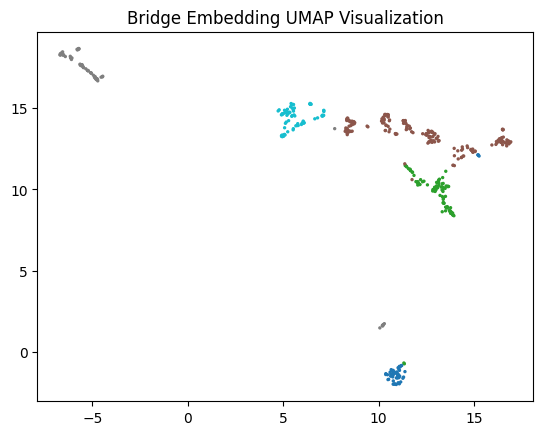

In [28]:
import umap
import matplotlib.pyplot as plt

umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(embeddings)
plt.scatter(umap_emb[:,0], umap_emb[:,1], s=2, c=labels, cmap='tab10')
plt.title("Bridge Embedding UMAP Visualization")
plt.show()
